<a href="https://colab.research.google.com/github/edoofra/Mushrooms_Secondary_Dataset_ClassPrediction/blob/main/ProgettoMLDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROGETTO MACHINE LEARNING ANDREOCCHI-BARGNANI-FRATUS

## Import e funzioni di utilità

In [1]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
data_path = "/content/drive/Shareddrives/machineLearning/mushrooms"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pandas_profiling as pp
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from typing import List
from scipy.stats import chi2_contingency

plt.rc('figure', max_open_warning = 0)

Mounted at /content/drive


In [2]:
# converto gli attributi da oggetti a numeri con il LabelEncoder
from sklearn.preprocessing import LabelEncoder
class MultiColumnLabelEncoder:

    def __init__(self, columns=None):
        self.columns = columns # array of column names to encode


    def fit(self, X, y=None):
        self.encoders = {}
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self


    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col])
        return output


    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)


    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col])
        return output

In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "progettoMLDM"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

## Analisi Preliminare del Dataset


### Import e Creazione Dataset v3

In [5]:
data_set = pd.read_csv(data_path + "/secondary_data.csv", sep=";")
data_set = data_set.sample(frac = 1, random_state=42)

Il dataset originario del problema è costituito da attributi di tipo float e di tipo categoriale, recanti delle sigle che descrivono le caratteristiche fisiche dei funghi.
Sostituisco le sigle con il loro significato, al fine di avere un dataset più autoesplicativo.

In [6]:

#data_set["stem-surface"].fillna("missing",inplace=True)

data_set.loc[data_set["cap-shape"]=="b","cap-shape"] = "bell"
data_set.loc[data_set["cap-shape"]=="c","cap-shape"] = "conical"
data_set.loc[data_set["cap-shape"]=="x","cap-shape"] = "convex"
data_set.loc[data_set["cap-shape"]=="f","cap-shape"] = "flat"
data_set.loc[data_set["cap-shape"]=="s","cap-shape"] = "sunken"
data_set.loc[data_set["cap-shape"]=="p","cap-shape"] = "spherical"
data_set.loc[data_set["cap-shape"]=="o","cap-shape"] = "others"

data_set.loc[data_set["cap-surface"]=="i","cap-surface"] = "fibrous"
data_set.loc[data_set["cap-surface"]=="g","cap-surface"] = "grooves"
data_set.loc[data_set["cap-surface"]=="d","cap-surface"] = "dry"
data_set.loc[data_set["cap-surface"]=="y","cap-surface"] = "scaly"
data_set.loc[data_set["cap-surface"]=="s","cap-surface"] = "smooth"
data_set.loc[data_set["cap-surface"]=="h","cap-surface"] = "shiny"
data_set.loc[data_set["cap-surface"]=="l","cap-surface"] = "leathery"
data_set.loc[data_set["cap-surface"]=="k","cap-surface"] = "silky"
data_set.loc[data_set["cap-surface"]=="t","cap-surface"] = "sticky"
data_set.loc[data_set["cap-surface"]=="w","cap-surface"] = "wrinkled"
data_set.loc[data_set["cap-surface"]=="e","cap-surface"] = "fleshy"

data_set.loc[data_set["cap-color"]=="n","cap-color"] = "brown"
data_set.loc[data_set["cap-color"]=="b","cap-color"] = "buff"
data_set.loc[data_set["cap-color"]=="g","cap-color"] = "gray"
data_set.loc[data_set["cap-color"]=="r","cap-color"] = "green"
data_set.loc[data_set["cap-color"]=="p","cap-color"] = "pink"
data_set.loc[data_set["cap-color"]=="u","cap-color"] = "purple"
data_set.loc[data_set["cap-color"]=="e","cap-color"] = "red"
data_set.loc[data_set["cap-color"]=="w","cap-color"] = "white"
data_set.loc[data_set["cap-color"]=="y","cap-color"] = "yellow"
data_set.loc[data_set["cap-color"]=="l","cap-color"] = "blue"
data_set.loc[data_set["cap-color"]=="o","cap-color"] = "orange"
data_set.loc[data_set["cap-color"]=="k","cap-color"] = "black"

data_set.loc[data_set["gill-attachment"]=="a","gill-attachment"] = "adnate"
data_set.loc[data_set["gill-attachment"]=="x","gill-attachment"] = "adnexed"
data_set.loc[data_set["gill-attachment"]=="d","gill-attachment"] = "decurrent"
data_set.loc[data_set["gill-attachment"]=="e","gill-attachment"] = "free"
data_set.loc[data_set["gill-attachment"]=="s","gill-attachment"] = "sinuate"
data_set.loc[data_set["gill-attachment"]=="p","gill-attachment"] = "pores"
data_set.loc[data_set["gill-attachment"]=="f","gill-attachment"] = "none"
data_set.loc[data_set["gill-attachment"]=="?","gill-attachment"] = "unknown"

data_set.loc[data_set["gill-spacing"]=="c","gill-spacing"] = "close"
data_set.loc[data_set["gill-spacing"]=="d","gill-spacing"] = "distant"
data_set.loc[data_set["gill-spacing"]=="f","gill-spacing"] = "none"

data_set.loc[data_set["gill-color"]=="n","gill-color"] = "brown"
data_set.loc[data_set["gill-color"]=="b","gill-color"] = "buff"
data_set.loc[data_set["gill-color"]=="g","gill-color"] = "gray"
data_set.loc[data_set["gill-color"]=="r","gill-color"] = "green"
data_set.loc[data_set["gill-color"]=="p","gill-color"] = "pink"
data_set.loc[data_set["gill-color"]=="u","gill-color"] = "purple"
data_set.loc[data_set["gill-color"]=="e","gill-color"] = "red"
data_set.loc[data_set["gill-color"]=="w","gill-color"] = "white"
data_set.loc[data_set["gill-color"]=="y","gill-color"] = "yellow"
data_set.loc[data_set["gill-color"]=="l","gill-color"] = "blue"
data_set.loc[data_set["gill-color"]=="o","gill-color"] = "orange"
data_set.loc[data_set["gill-color"]=="k","gill-color"] = "black"
data_set.loc[data_set["gill-color"]=="f","gill-color"] = "none"

data_set.loc[data_set["stem-root"]=="b","stem-root"] = "bulbous"
data_set.loc[data_set["stem-root"]=="s","stem-root"] = "swollen"
data_set.loc[data_set["stem-root"]=="c","stem-root"] = "club"
data_set.loc[data_set["stem-root"]=="u","stem-root"] = "cup"
data_set.loc[data_set["stem-root"]=="e","stem-root"] = "equal"
data_set.loc[data_set["stem-root"]=="z","stem-root"] = "rhizomorphs"
data_set.loc[data_set["stem-root"]=="r","stem-root"] = "rooted"

data_set.loc[data_set["stem-surface"]=="i","stem-surface"] = "fibrous"
data_set.loc[data_set["stem-surface"]=="g","stem-surface"] = "grooves"
data_set.loc[data_set["stem-surface"]=="d","stem-surface"] = "dry"
data_set.loc[data_set["stem-surface"]=="y","stem-surface"] = "scaly"
data_set.loc[data_set["stem-surface"]=="s","stem-surface"] = "smooth"
data_set.loc[data_set["stem-surface"]=="h","stem-surface"] = "shiny"
data_set.loc[data_set["stem-surface"]=="l","stem-surface"] = "leathery"
data_set.loc[data_set["stem-surface"]=="k","stem-surface"] = "silky"
data_set.loc[data_set["stem-surface"]=="t","stem-surface"] = "sticky"
data_set.loc[data_set["stem-surface"]=="w","stem-surface"] = "wrinkled"
data_set.loc[data_set["stem-surface"]=="e","stem-surface"] = "fleshy"
data_set.loc[data_set["stem-surface"]=="f","stem-surface"] = "none"

data_set.loc[data_set["stem-color"]=="n","stem-color"] = "brown"
data_set.loc[data_set["stem-color"]=="b","stem-color"] = "buff"
data_set.loc[data_set["stem-color"]=="g","stem-color"] = "gray"
data_set.loc[data_set["stem-color"]=="r","stem-color"] = "green"
data_set.loc[data_set["stem-color"]=="p","stem-color"] = "pink"
data_set.loc[data_set["stem-color"]=="u","stem-color"] = "purple"
data_set.loc[data_set["stem-color"]=="e","stem-color"] = "red"
data_set.loc[data_set["stem-color"]=="w","stem-color"] = "white"
data_set.loc[data_set["stem-color"]=="y","stem-color"] = "yellow"
data_set.loc[data_set["stem-color"]=="l","stem-color"] = "blue"
data_set.loc[data_set["stem-color"]=="o","stem-color"] = "orange"
data_set.loc[data_set["stem-color"]=="k","stem-color"] = "black"
data_set.loc[data_set["stem-color"]=="f","stem-color"] = "none"

data_set.loc[data_set["veil-type"]=="u","veil-type"] = "universal"
data_set.loc[data_set["veil-type"]=="p","veil-type"] = "partial"

data_set.loc[data_set["veil-color"]=="n","veil-color"] = "brown"
data_set.loc[data_set["veil-color"]=="b","veil-color"] = "buff"
data_set.loc[data_set["veil-color"]=="g","veil-color"] = "gray"
data_set.loc[data_set["veil-color"]=="r","veil-color"] = "green"
data_set.loc[data_set["veil-color"]=="p","veil-color"] = "pink"
data_set.loc[data_set["veil-color"]=="u","veil-color"] = "purple"
data_set.loc[data_set["veil-color"]=="e","veil-color"] = "red"
data_set.loc[data_set["veil-color"]=="w","veil-color"] = "white"
data_set.loc[data_set["veil-color"]=="y","veil-color"] = "yellow"
data_set.loc[data_set["veil-color"]=="l","veil-color"] = "blue"
data_set.loc[data_set["veil-color"]=="o","veil-color"] = "orange"
data_set.loc[data_set["veil-color"]=="k","veil-color"] = "black"
data_set.loc[data_set["veil-color"]=="f","veil-color"] = "none"

data_set.loc[data_set["ring-type"]=="c","ring-type"] = "cobwebby"
data_set.loc[data_set["ring-type"]=="e","ring-type"] = "evanescent"
data_set.loc[data_set["ring-type"]=="r","ring-type"] = "flyring"
data_set.loc[data_set["ring-type"]=="g","ring-type"] = "grooved"
data_set.loc[data_set["ring-type"]=="l","ring-type"] = "large"
data_set.loc[data_set["ring-type"]=="p","ring-type"] = "pendance"
data_set.loc[data_set["ring-type"]=="s","ring-type"] = "sheathing"
data_set.loc[data_set["ring-type"]=="z","ring-type"] = "zone"
data_set.loc[data_set["ring-type"]=="y","ring-type"] = "scaly"
data_set.loc[data_set["ring-type"]=="m","ring-type"] = "movable"
data_set.loc[data_set["ring-type"]=="f","ring-type"] = "none"
data_set.loc[data_set["ring-type"]=="?","ring-type"] = "unknown"

data_set.loc[data_set["spore-print-color"]=="n","spore-print-color"] = "brown"
data_set.loc[data_set["spore-print-color"]=="b","spore-print-color"] = "buff"
data_set.loc[data_set["spore-print-color"]=="g","spore-print-color"] = "gray"
data_set.loc[data_set["spore-print-color"]=="r","spore-print-color"] = "green"
data_set.loc[data_set["spore-print-color"]=="p","spore-print-color"] = "pink"
data_set.loc[data_set["spore-print-color"]=="u","spore-print-color"] = "purple"
data_set.loc[data_set["spore-print-color"]=="e","spore-print-color"] = "red"
data_set.loc[data_set["spore-print-color"]=="w","spore-print-color"] = "white"
data_set.loc[data_set["spore-print-color"]=="y","spore-print-color"] = "yellow"
data_set.loc[data_set["spore-print-color"]=="l","spore-print-color"] = "blue"
data_set.loc[data_set["spore-print-color"]=="o","spore-print-color"] = "orange"
data_set.loc[data_set["spore-print-color"]=="k","spore-print-color"] = "black"

data_set.loc[data_set["habitat"]=="g","habitat"] = "grasses"
data_set.loc[data_set["habitat"]=="l","habitat"] = "leaves"
data_set.loc[data_set["habitat"]=="m","habitat"] = "meadows"
data_set.loc[data_set["habitat"]=="p","habitat"] = "paths"
data_set.loc[data_set["habitat"]=="h","habitat"] = "heaths"
data_set.loc[data_set["habitat"]=="u","habitat"] = "urban"
data_set.loc[data_set["habitat"]=="w","habitat"] = "waste"
data_set.loc[data_set["habitat"]=="d","habitat"] = "woods"

data_set.loc[data_set["season"]=="s","season"] = "spring"
data_set.loc[data_set["season"]=="u","season"] = "summer"
data_set.loc[data_set["season"]=="a","season"] = "autumn"
data_set.loc[data_set["season"]=="w","season"] = "winter"





In [7]:
pip install -U pandas-profiling


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 325 kB 6.2 MB/s 
     |████████████████████████████████| 9.9 MB 51.3 MB/s 
     |████████████████████████████████| 102 kB 46.6 MB/s 
     |████████████████████████████████| 679 kB 48.2 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 4.7 MB 39.2 MB/s 
     |████████████████████████████████| 296 kB 66.5 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=0304c584a21634f6e2aac92ec916f2925f4a6713a315337c33ee9f8f032af39c
  Stored in directory: /root/.cache/pip/wheels/23/14/6e/4be5bfeeb027f4939a01764b48edd5996acf574b0913fe5243
Successfully built htmlmin
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1
  Attempting uninstall: statsmodels
    Found e

In [8]:
from pandas_profiling import ProfileReport

In [9]:
profile = ProfileReport(data_set)

In [10]:
#profile

### Analisi preliminare caratteristiche del dataset

In [11]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61069 entries, 11541 to 56422
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color     

Possiamo vedere che il nostro dataset è composto da 61069 istanze, ognuna con 19 features più la classe. Possiamo inoltre notare la presenza di missing values su alcune delle features.

In [12]:
#Chiamiamo train_set tutto il data_set semplicemente perchè lo utilizziamo per lavorare sui dati. Lo split avverrà in fase di creazione del modello
train_set = data_set
train_set


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
11541,e,1.32,conical,grooves,brown,f,adnate,NaN,gray,4.41,...,NaN,NaN,gray,NaN,NaN,f,none,NaN,leaves,autumn
35700,p,4.41,convex,shiny,orange,f,adnate,close,brown,4.18,...,NaN,scaly,orange,NaN,NaN,t,zone,NaN,woods,winter
55781,e,9.23,others,NaN,brown,f,NaN,NaN,white,4.50,...,NaN,NaN,brown,NaN,NaN,f,none,NaN,woods,autumn
29303,p,3.16,flat,wrinkled,brown,t,decurrent,close,yellow,3.13,...,NaN,NaN,brown,NaN,NaN,f,none,NaN,woods,summer
46601,e,3.71,convex,shiny,brown,f,NaN,close,brown,5.85,...,NaN,smooth,white,NaN,white,f,none,black,woods,autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,p,5.52,sunken,dry,yellow,f,decurrent,close,yellow,2.47,...,NaN,NaN,orange,NaN,NaN,f,none,NaN,heaths,summer
38158,p,7.68,convex,fleshy,brown,f,adnate,NaN,brown,11.95,...,swollen,NaN,brown,NaN,brown,f,none,NaN,heaths,autumn
860,p,12.28,flat,NaN,brown,f,free,NaN,white,10.79,...,NaN,NaN,white,universal,white,t,grooved,NaN,woods,summer
15795,p,6.78,convex,smooth,brown,t,sinuate,distant,green,6.43,...,rooted,scaly,white,NaN,NaN,f,none,NaN,woods,summer


In [13]:
train_set.describe()

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


Possiamo subito notare come il dataset sia abbastanza completo in termini di dati, infatti abbiamo dei missing values principalemente per quanto riguarda la radice e la superficie del gambo, il velo del fungo e il colore delle spore.
Dal describe possiamo inoltre notare come siano presenti sicuramente dei valori di outlier nelle features numeriche, dato che il valore massimo si discosta molto dal valore medio.


Procediamo ora con la visualizzazione grafica del trainset, in modo da andare a visualizzare la distribuzione dei dati 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

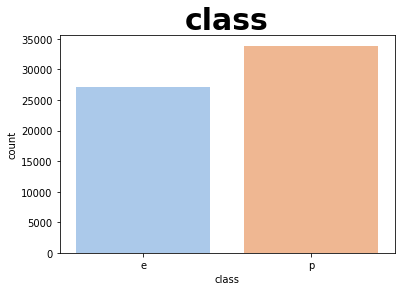

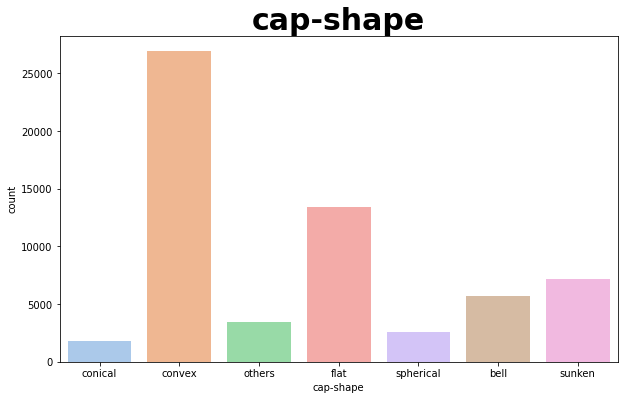

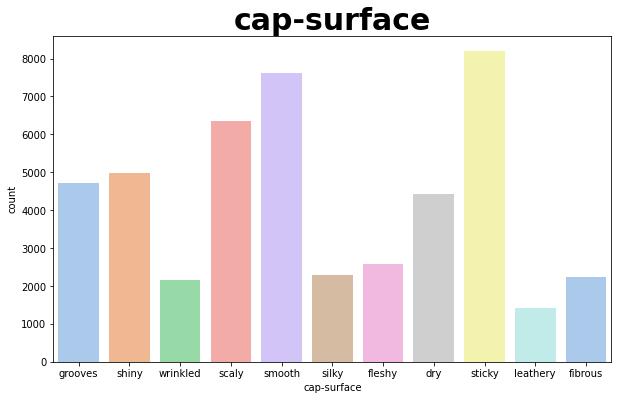

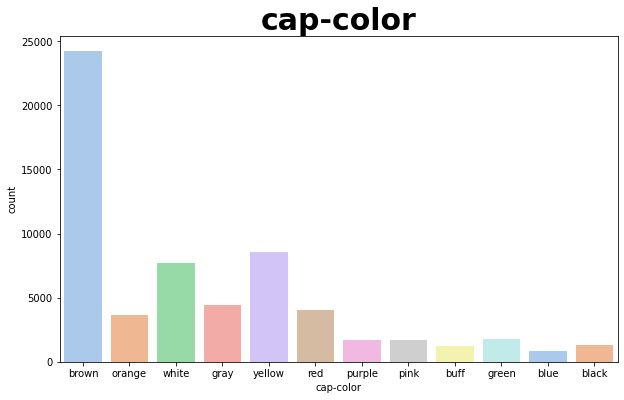

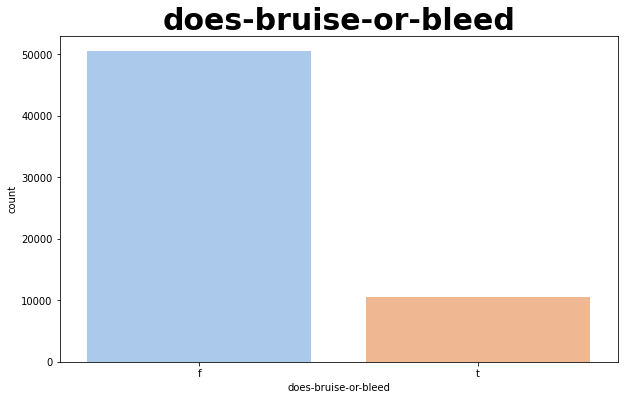

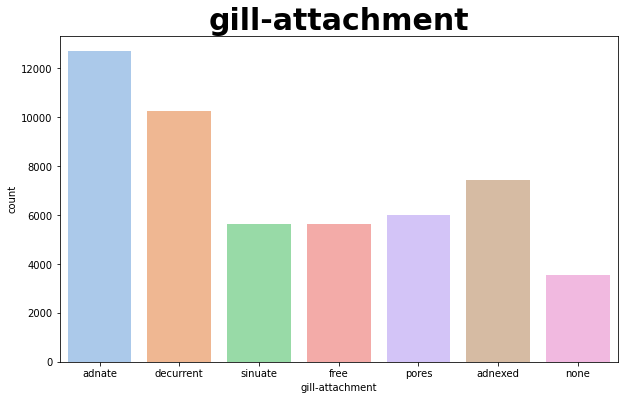

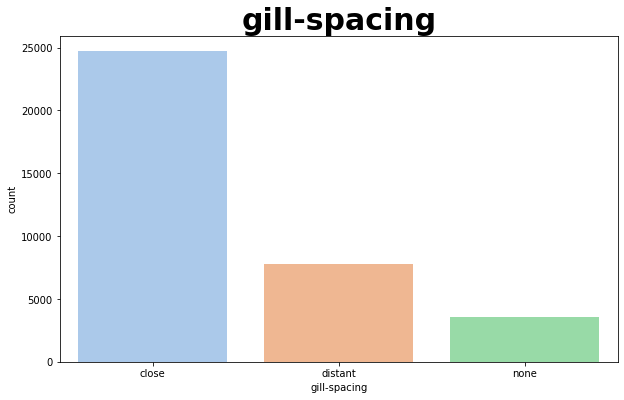

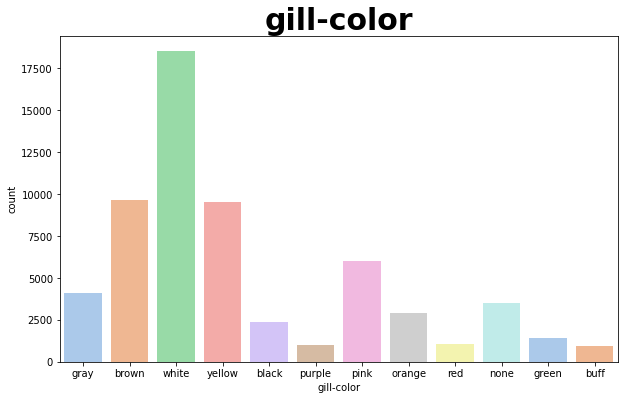

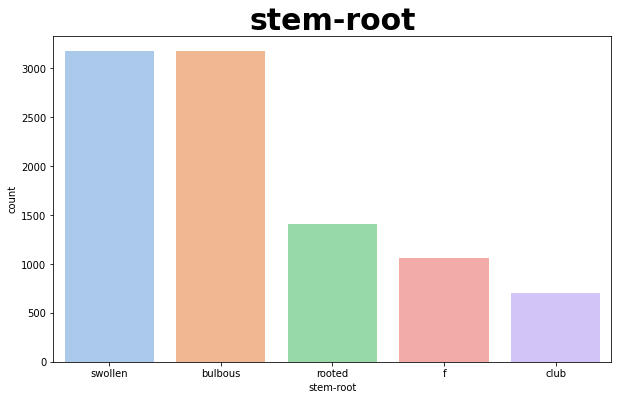

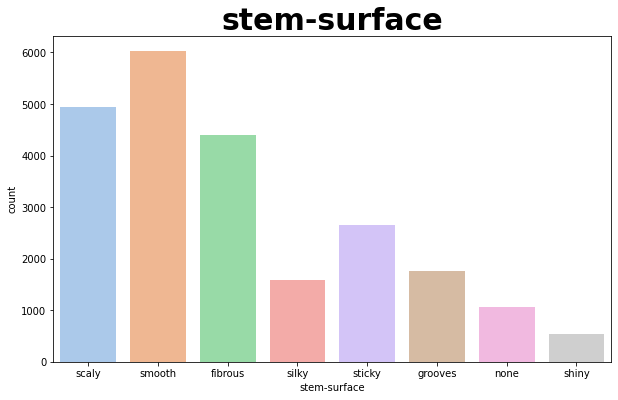

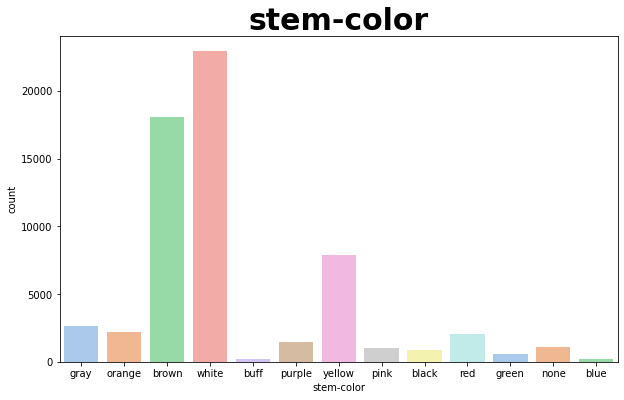

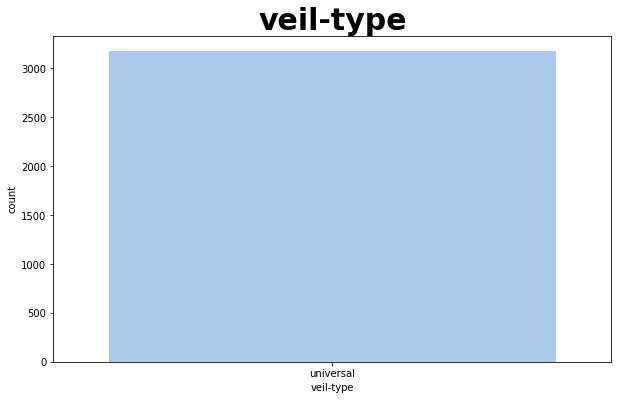

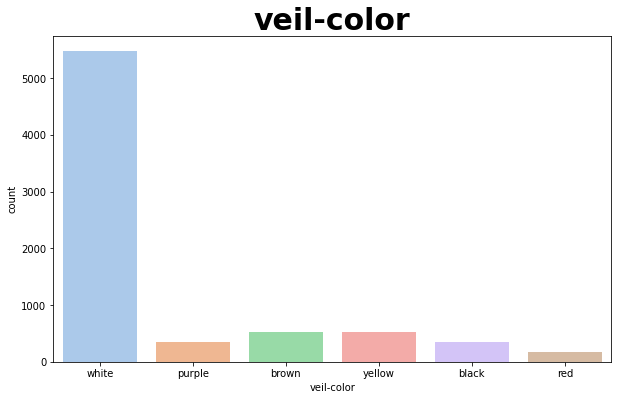

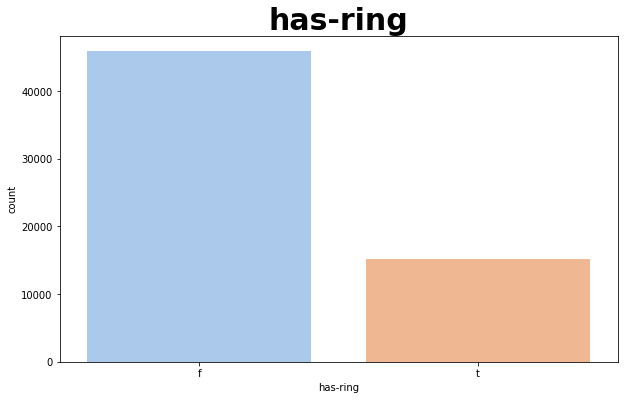

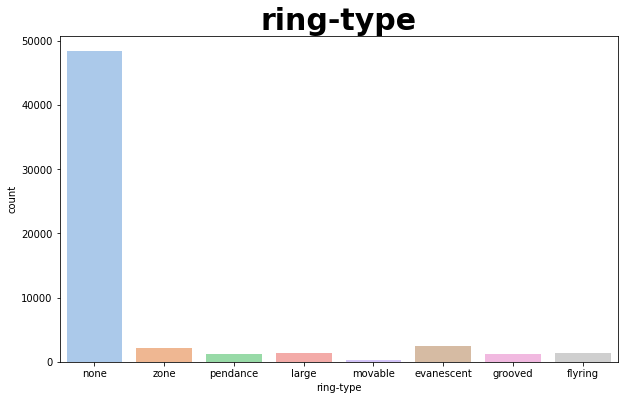

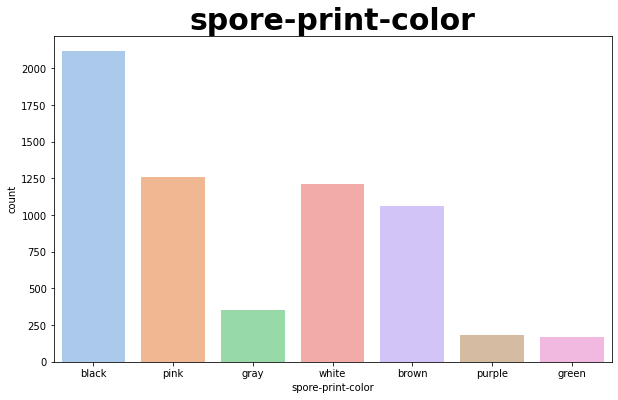

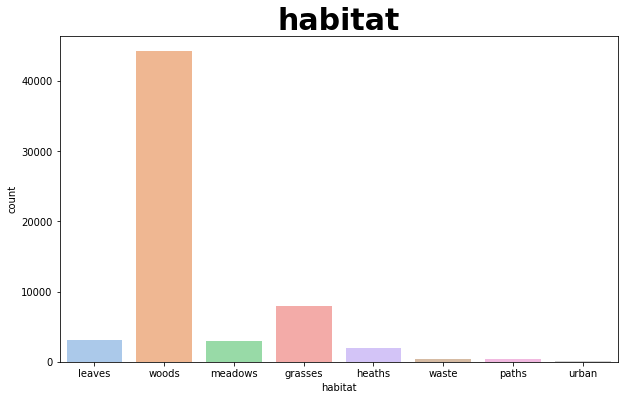

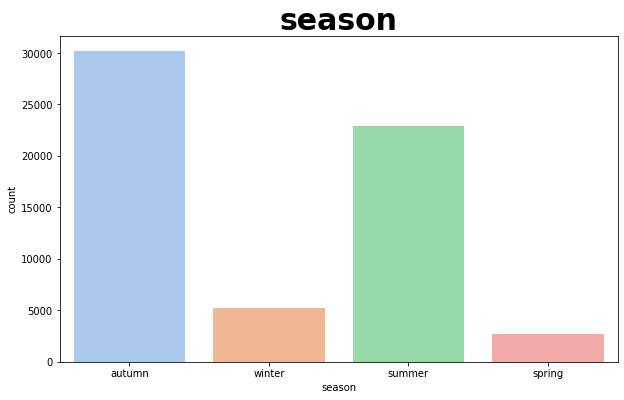

In [14]:
import seaborn as sns
object_to_number = train_set.select_dtypes("object")
for column in object_to_number:
  plt.figure()
  plt.title(label=column,
          fontsize=30,fontweight="bold")
  s = sns.countplot(train_set[column], palette="pastel")
  plt.rcParams['figure.figsize']=(10,6)

Dall'analisi possiamo evincere come le varibaili 'ring-type' e 'habitat' siano costanti per la maggior parte delle istanze e quindi ipotizziamo siano poco importanti per la classificazione del problema. Notiamo anche che esistono anche altre variabili con un valore predominante, anche se in misura minore rispetto alle due citate in precedenza.
Oltre a questo, possiamo notare che all'interno del nostro trainset non abbiamo un numero uguale di istanze per le classi, e questo potrebbe essere un problema.

## Preprocessing dei dati


### Analisi dei missing values

In [15]:
# recupero le colonne con valori nulli
train_set.columns[pd.isna(train_set).any()]

Index(['cap-surface', 'gill-attachment', 'gill-spacing', 'stem-root',
       'stem-surface', 'veil-type', 'veil-color', 'ring-type',
       'spore-print-color'],
      dtype='object')

In [16]:
def count_missing(ds: pd.DataFrame):
    return ds.shape[0] - ds.count()

In [17]:
count_missing(train_set)

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64

**Percentuale di missing values nel train_set**

cap-surface: 23%

gill-attachment: 16%

gill-spacing: 41%

stem-root: 84%

stem-surface: 62%

veil-type: 95%

veil-color: 88%

ring-type: 4%

spore-print-color: 90%

Di conseguenza, decidiamo di eliminare dal dataset le colonne che presentano una percentuale di missing values maggiore del 50%. Per le altre eseguiremo un'analisi per ricostruire i dati mancanti.

In [18]:
train_set.drop(['stem-root','stem-surface','veil-type','veil-color','spore-print-color'],axis=1,inplace=True)
train_set

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
11541,e,1.32,conical,grooves,brown,f,adnate,NaN,gray,4.41,1.28,gray,f,none,leaves,autumn
35700,p,4.41,convex,shiny,orange,f,adnate,close,brown,4.18,6.21,orange,t,zone,woods,winter
55781,e,9.23,others,NaN,brown,f,NaN,NaN,white,4.50,20.78,brown,f,none,woods,autumn
29303,p,3.16,flat,wrinkled,brown,t,decurrent,close,yellow,3.13,5.61,brown,f,none,woods,summer
46601,e,3.71,convex,shiny,brown,f,NaN,close,brown,5.85,6.52,white,f,none,woods,autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,p,5.52,sunken,dry,yellow,f,decurrent,close,yellow,2.47,5.92,orange,f,none,heaths,summer
38158,p,7.68,convex,fleshy,brown,f,adnate,NaN,brown,11.95,15.31,brown,f,none,heaths,autumn
860,p,12.28,flat,NaN,brown,f,free,NaN,white,10.79,13.30,white,t,grooved,woods,summer
15795,p,6.78,convex,smooth,brown,t,sinuate,distant,green,6.43,16.30,white,f,none,woods,summer


In [19]:
count_missing(train_set)

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-color                  0
has-ring                    0
ring-type                2471
habitat                     0
season                      0
dtype: int64

### Eliminazione outliers

Prima di procedere con la ricostruzione dei missing values abbiamo deciso di analizzare il dataset alla ricerca di valori di outlier, in modo da eliminarli ed evitare che essi possano influenzare negativamente la stima dei valori mancanti.

In [20]:
# definizione funzione per rimozione outlier
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        mean = df[col].mean()
        sd = df[col].std()
        df = df[(df[col] <= mean+(n_std*sd))]
    return df

In [21]:
train_set.describe()

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


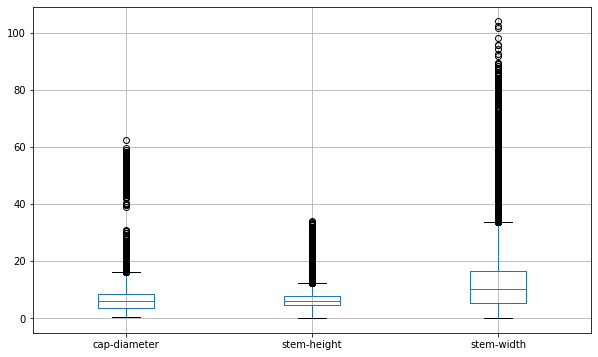

In [22]:
boxplot_prima = train_set.boxplot(column=['cap-diameter','stem-height','stem-width'])

In [23]:
train_set=remove_outliers(train_set,['cap-diameter','stem-height','stem-width'],2)

Working on column: cap-diameter
Working on column: stem-height
Working on column: stem-width


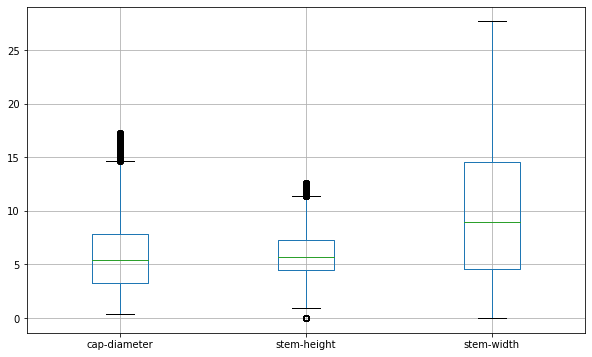

In [24]:
boxplot_dopo = train_set.boxplot(column=['cap-diameter','stem-height','stem-width'])

In [25]:
train_set.describe()

,cap-diameter,stem-height,stem-width
count,54614.000000,54614.000000,54614.000000
mean,5.801475,5.953751,10.063094
std,3.276876,2.301243,6.699734
min,0.380000,0.000000,0.000000
25%,3.290000,4.490000,4.560000
50%,5.380000,5.730000,8.920000
75%,7.850000,7.250000,14.540000
max,17.260000,12.560000,27.690000


Andiamo ora ad analizzare la variazione del train_set dopo l'eliminazione degli outliers in via grafica

Saving figure attribute_histogram_plots_no_outliers


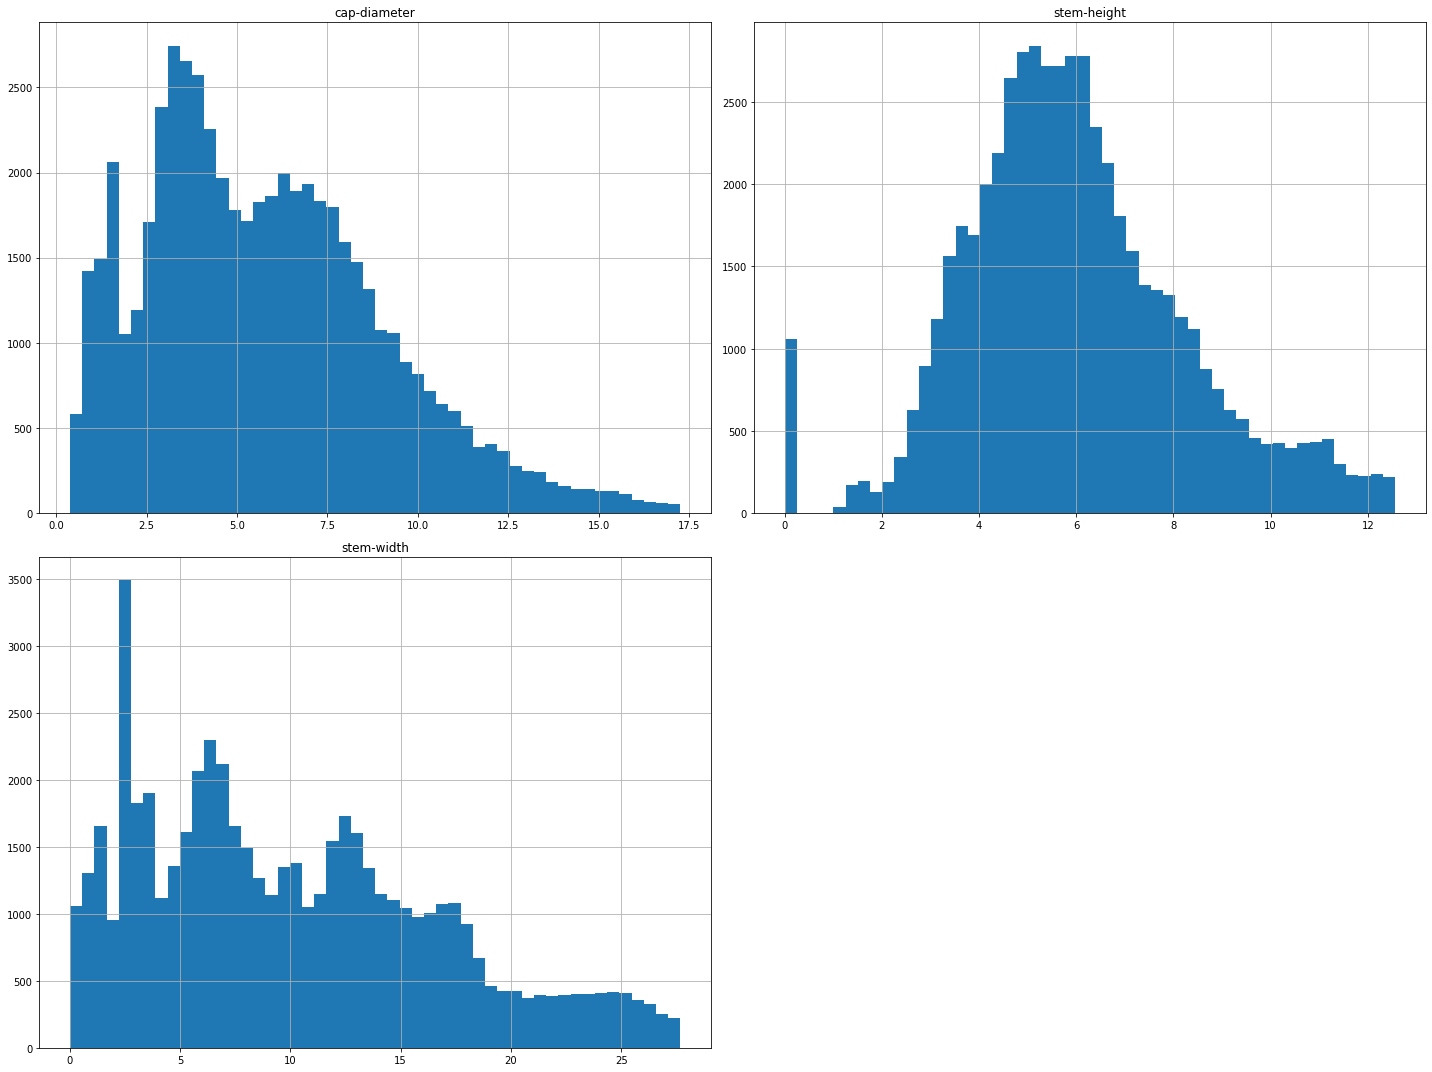

In [26]:
train_set.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots_no_outliers")
plt.show()

### Ricostruzione Missing Values

Abbiamo deciso di testare diverse tecniche per stimare i missing values e di mantenere i relativi trainset fino alla fine, in modo da addestrarli tutti e valutare quale sia stata la tecnica migliore.

#### Metodo 1: eliminazione dei record con missing values

Come prima ipotesi decidiamo di droppare le righe contenenti un missing value, salviamo l'output come un nuovo dataset.

In [27]:
train_set_metodo1 = train_set.dropna()
train_set_metodo1

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
35700,p,4.41,convex,shiny,orange,f,adnate,close,brown,4.18,6.21,orange,t,zone,woods,winter
29303,p,3.16,flat,wrinkled,brown,t,decurrent,close,yellow,3.13,5.61,brown,f,none,woods,summer
40729,p,3.03,convex,sticky,brown,f,sinuate,close,brown,5.74,9.32,white,t,zone,woods,summer
7729,p,4.82,flat,leathery,red,f,adnexed,distant,brown,6.13,5.05,yellow,f,none,woods,summer
25455,p,7.42,flat,sticky,red,f,adnexed,distant,white,5.95,16.59,white,f,none,woods,autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16023,e,5.54,flat,shiny,gray,f,sinuate,distant,white,5.09,10.14,gray,f,none,woods,autumn
60788,p,1.10,flat,smooth,yellow,f,none,none,none,2.78,4.90,yellow,f,none,woods,summer
37194,p,4.08,bell,scaly,green,f,sinuate,close,gray,6.42,6.71,white,t,evanescent,grasses,summer
54343,p,5.52,sunken,dry,yellow,f,decurrent,close,yellow,2.47,5.92,orange,f,none,heaths,summer


In [28]:
count_missing(train_set_metodo1)

class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

In [29]:
object_to_number = train_set.select_dtypes("object")
multi = MultiColumnLabelEncoder(columns=object_to_number.columns)
train_set_metodo1_float = multi.fit_transform(train_set_metodo1)
train_set_metodo1_float

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
35700,1,4.41,2,6,6,0,0,0,1,4.18,6.21,6,1,4,6,3
29303,1,3.16,3,10,2,1,2,0,11,3.13,5.61,2,0,3,6,2
40729,1,3.03,2,9,2,0,6,0,1,5.74,9.32,10,1,4,6,2
7729,1,4.82,3,4,9,0,1,1,1,6.13,5.05,11,0,3,6,2
25455,1,7.42,3,9,9,0,1,1,10,5.95,16.59,10,0,3,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16023,0,5.54,3,6,4,0,6,1,10,5.09,10.14,3,0,3,6,0
60788,1,1.10,3,8,11,0,4,2,5,2.78,4.90,11,0,3,6,2
37194,1,4.08,0,5,5,0,6,0,3,6.42,6.71,10,1,0,0,2
54343,1,5.52,6,0,11,0,2,0,11,2.47,5.92,6,0,3,1,2


#### Metodo 2: stima di missing values tramite valore più frequente




In [30]:
def array_to_dataframe(arr: np.ndarray, columns: List[str]):
    return pd.DataFrame(data=arr, columns=columns)

In [31]:
train_set_metodo2 = SimpleImputer(strategy="most_frequent").fit_transform(train_set)
train_set_metodo2 = array_to_dataframe(arr=train_set_metodo2, columns=train_set.columns)
train_set_metodo2

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,e,1.32,conical,grooves,brown,f,adnate,close,gray,4.41,1.28,gray,f,none,leaves,autumn
1,p,4.41,convex,shiny,orange,f,adnate,close,brown,4.18,6.21,orange,t,zone,woods,winter
2,e,9.23,others,sticky,brown,f,adnate,close,white,4.5,20.78,brown,f,none,woods,autumn
3,p,3.16,flat,wrinkled,brown,t,decurrent,close,yellow,3.13,5.61,brown,f,none,woods,summer
4,e,3.71,convex,shiny,brown,f,adnate,close,brown,5.85,6.52,white,f,none,woods,autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54609,p,5.52,sunken,dry,yellow,f,decurrent,close,yellow,2.47,5.92,orange,f,none,heaths,summer
54610,p,7.68,convex,fleshy,brown,f,adnate,close,brown,11.95,15.31,brown,f,none,heaths,autumn
54611,p,12.28,flat,sticky,brown,f,free,close,white,10.79,13.3,white,t,grooved,woods,summer
54612,p,6.78,convex,smooth,brown,t,sinuate,distant,green,6.43,16.3,white,f,none,woods,summer


In [32]:
train_set_metodo2[['cap-diameter','stem-height','stem-width']]=train_set_metodo2[['cap-diameter','stem-height','stem-width']].astype('float64')

In [33]:
train_set_metodo2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54614 entries, 0 to 54613
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 54614 non-null  object 
 1   cap-diameter          54614 non-null  float64
 2   cap-shape             54614 non-null  object 
 3   cap-surface           54614 non-null  object 
 4   cap-color             54614 non-null  object 
 5   does-bruise-or-bleed  54614 non-null  object 
 6   gill-attachment       54614 non-null  object 
 7   gill-spacing          54614 non-null  object 
 8   gill-color            54614 non-null  object 
 9   stem-height           54614 non-null  float64
 10  stem-width            54614 non-null  float64
 11  stem-color            54614 non-null  object 
 12  has-ring              54614 non-null  object 
 13  ring-type             54614 non-null  object 
 14  habitat               54614 non-null  object 
 15  season             

In [34]:
count_missing(train_set_metodo2)

class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

In [35]:
multi = MultiColumnLabelEncoder(columns=object_to_number.columns)
train_set_metodo2_float = multi.fit_transform(train_set_metodo2)
train_set_metodo2_float

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,0,1.32,1,3,2,0,0,0,3,4.41,1.28,4,0,4,2,0
1,1,4.41,2,6,6,0,0,0,1,4.18,6.21,7,1,6,7,3
2,0,9.23,4,9,2,0,0,0,10,4.50,20.78,2,0,4,7,0
3,1,3.16,3,10,2,1,2,0,11,3.13,5.61,2,0,4,7,2
4,0,3.71,2,6,2,0,0,0,1,5.85,6.52,11,0,4,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54609,1,5.52,6,0,11,0,2,0,11,2.47,5.92,7,0,4,1,2
54610,1,7.68,2,2,2,0,0,0,1,11.95,15.31,2,0,4,1,0
54611,1,12.28,3,9,2,0,3,0,10,10.79,13.30,11,1,2,7,2
54612,1,6.78,2,8,2,1,6,1,4,6.43,16.30,11,0,4,7,2


#### Metodo 3: stima dei missing values tramite KNearestNeighbours

L'imputazione dei vissing values tramite la tecnica del KNN consiste nel calcolare la distanza fra le varie istanze del dataset e le istanze contenenti dei missing values, in modo da fillarli successivamente usando il valore medio delle K istanze più vicine a quelle contenenti i missing values.
Per questo, abbiamo bisogno di un dataset contenente attributi di tipo numerico, dobbiamo quindi convertire prima il nostro dataset.

##### Conversione tipo attributi

In [36]:
train_set

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
11541,e,1.32,conical,grooves,brown,f,adnate,NaN,gray,4.41,1.28,gray,f,none,leaves,autumn
35700,p,4.41,convex,shiny,orange,f,adnate,close,brown,4.18,6.21,orange,t,zone,woods,winter
55781,e,9.23,others,NaN,brown,f,NaN,NaN,white,4.50,20.78,brown,f,none,woods,autumn
29303,p,3.16,flat,wrinkled,brown,t,decurrent,close,yellow,3.13,5.61,brown,f,none,woods,summer
46601,e,3.71,convex,shiny,brown,f,NaN,close,brown,5.85,6.52,white,f,none,woods,autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,p,5.52,sunken,dry,yellow,f,decurrent,close,yellow,2.47,5.92,orange,f,none,heaths,summer
38158,p,7.68,convex,fleshy,brown,f,adnate,NaN,brown,11.95,15.31,brown,f,none,heaths,autumn
860,p,12.28,flat,NaN,brown,f,free,NaN,white,10.79,13.30,white,t,grooved,woods,summer
15795,p,6.78,convex,smooth,brown,t,sinuate,distant,green,6.43,16.30,white,f,none,woods,summer


In [37]:
from numpy.lib.twodim_base import mask_indices
# creo una maschera per identificare i missing values
original = train_set
mask = train_set.isnull()
mask

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
11541,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
35700,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
55781,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False
29303,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
46601,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
38158,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
860,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False
15795,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [38]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54614 entries, 11541 to 56422
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 54614 non-null  object 
 1   cap-diameter          54614 non-null  float64
 2   cap-shape             54614 non-null  object 
 3   cap-surface           41171 non-null  object 
 4   cap-color             54614 non-null  object 
 5   does-bruise-or-bleed  54614 non-null  object 
 6   gill-attachment       45525 non-null  object 
 7   gill-spacing          33465 non-null  object 
 8   gill-color            54614 non-null  object 
 9   stem-height           54614 non-null  float64
 10  stem-width            54614 non-null  float64
 11  stem-color            54614 non-null  object 
 12  has-ring              54614 non-null  object 
 13  ring-type             52210 non-null  object 
 14  habitat               54614 non-null  object 
 15  season         

In [39]:
object_to_number = train_set.select_dtypes("object")

multi = MultiColumnLabelEncoder(columns=object_to_number.columns)

In [40]:
train_set_metodo3_float = multi.fit_transform(train_set)
train_set_metodo3_float

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
11541,0,1.32,1,3,2,0,0,3,3,4.41,1.28,4,0,4,2,0
35700,1,4.41,2,6,6,0,0,0,1,4.18,6.21,7,1,6,7,3
55781,0,9.23,4,11,2,0,7,3,10,4.50,20.78,2,0,4,7,0
29303,1,3.16,3,10,2,1,2,0,11,3.13,5.61,2,0,4,7,2
46601,0,3.71,2,6,2,0,7,0,1,5.85,6.52,11,0,4,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,1,5.52,6,0,11,0,2,0,11,2.47,5.92,7,0,4,1,2
38158,1,7.68,2,2,2,0,0,3,1,11.95,15.31,2,0,4,1,0
860,1,12.28,3,11,2,0,3,3,10,10.79,13.30,11,1,2,7,2
15795,1,6.78,2,8,2,1,6,1,4,6.43,16.30,11,0,4,7,2


In [41]:
train_set_metodo3 = train_set_metodo3_float.where(~mask, original)

train_set_metodo3
#count_missing(train_set_metodo3)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
11541,0,1.32,1,3,2,0,0,NaN,3,4.41,1.28,4,0,4,2,0
35700,1,4.41,2,6,6,0,0,0,1,4.18,6.21,7,1,6,7,3
55781,0,9.23,4,NaN,2,0,NaN,NaN,10,4.50,20.78,2,0,4,7,0
29303,1,3.16,3,10,2,1,2,0,11,3.13,5.61,2,0,4,7,2
46601,0,3.71,2,6,2,0,NaN,0,1,5.85,6.52,11,0,4,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,1,5.52,6,0,11,0,2,0,11,2.47,5.92,7,0,4,1,2
38158,1,7.68,2,2,2,0,0,NaN,1,11.95,15.31,2,0,4,1,0
860,1,12.28,3,NaN,2,0,3,NaN,10,10.79,13.30,11,1,2,7,2
15795,1,6.78,2,8,2,1,6,1,4,6.43,16.30,11,0,4,7,2


In [42]:
train_set_metodo3 = KNNImputer().fit_transform(train_set_metodo3)
train_set_metodoKNN = array_to_dataframe(arr=train_set_metodo3, columns=train_set.columns)
train_set_metodoKNN

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,0.0,1.32,1.0,3.0,2.0,0.0,0.0,0.0,3.0,4.41,1.28,4.0,0.0,4.0,2.0,0.0
1,1.0,4.41,2.0,6.0,6.0,0.0,0.0,0.0,1.0,4.18,6.21,7.0,1.0,6.0,7.0,3.0
2,0.0,9.23,4.0,7.8,2.0,0.0,5.0,0.0,10.0,4.50,20.78,2.0,0.0,4.0,7.0,0.0
3,1.0,3.16,3.0,10.0,2.0,1.0,2.0,0.0,11.0,3.13,5.61,2.0,0.0,4.0,7.0,2.0
4,0.0,3.71,2.0,6.0,2.0,0.0,0.8,0.0,1.0,5.85,6.52,11.0,0.0,4.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54609,1.0,5.52,6.0,0.0,11.0,0.0,2.0,0.0,11.0,2.47,5.92,7.0,0.0,4.0,1.0,2.0
54610,1.0,7.68,2.0,2.0,2.0,0.0,0.0,0.0,1.0,11.95,15.31,2.0,0.0,4.0,1.0,0.0
54611,1.0,12.28,3.0,3.8,2.0,0.0,3.0,0.0,10.0,10.79,13.30,11.0,1.0,2.0,7.0,2.0
54612,1.0,6.78,2.0,8.0,2.0,1.0,6.0,1.0,4.0,6.43,16.30,11.0,0.0,4.0,7.0,2.0


In [43]:
train_set_metodoKNN[object_to_number.columns] = train_set_metodoKNN[object_to_number.columns].round(decimals=0)
train_set_metodoKNN

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,0.0,1.32,1.0,3.0,2.0,0.0,0.0,0.0,3.0,4.41,1.28,4.0,0.0,4.0,2.0,0.0
1,1.0,4.41,2.0,6.0,6.0,0.0,0.0,0.0,1.0,4.18,6.21,7.0,1.0,6.0,7.0,3.0
2,0.0,9.23,4.0,8.0,2.0,0.0,5.0,0.0,10.0,4.50,20.78,2.0,0.0,4.0,7.0,0.0
3,1.0,3.16,3.0,10.0,2.0,1.0,2.0,0.0,11.0,3.13,5.61,2.0,0.0,4.0,7.0,2.0
4,0.0,3.71,2.0,6.0,2.0,0.0,1.0,0.0,1.0,5.85,6.52,11.0,0.0,4.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54609,1.0,5.52,6.0,0.0,11.0,0.0,2.0,0.0,11.0,2.47,5.92,7.0,0.0,4.0,1.0,2.0
54610,1.0,7.68,2.0,2.0,2.0,0.0,0.0,0.0,1.0,11.95,15.31,2.0,0.0,4.0,1.0,0.0
54611,1.0,12.28,3.0,4.0,2.0,0.0,3.0,0.0,10.0,10.79,13.30,11.0,1.0,2.0,7.0,2.0
54612,1.0,6.78,2.0,8.0,2.0,1.0,6.0,1.0,4.0,6.43,16.30,11.0,0.0,4.0,7.0,2.0


In [44]:
train_set_metodoKNN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54614 entries, 0 to 54613
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 54614 non-null  float64
 1   cap-diameter          54614 non-null  float64
 2   cap-shape             54614 non-null  float64
 3   cap-surface           54614 non-null  float64
 4   cap-color             54614 non-null  float64
 5   does-bruise-or-bleed  54614 non-null  float64
 6   gill-attachment       54614 non-null  float64
 7   gill-spacing          54614 non-null  float64
 8   gill-color            54614 non-null  float64
 9   stem-height           54614 non-null  float64
 10  stem-width            54614 non-null  float64
 11  stem-color            54614 non-null  float64
 12  has-ring              54614 non-null  float64
 13  ring-type             54614 non-null  float64
 14  habitat               54614 non-null  float64
 15  season             

In [45]:
train_set_metodoKNN[['class','cap-shape','cap-surface','cap-color','does-bruise-or-bleed','gill-attachment','gill-spacing','gill-color','stem-color','has-ring','ring-type','habitat','season']]=train_set_metodoKNN[['class','cap-shape','cap-surface','cap-color','does-bruise-or-bleed','gill-attachment','gill-spacing','gill-color','stem-color','has-ring','ring-type','habitat','season']].astype('int64')
inv_train_set_metodo3 = multi.inverse_transform(train_set_metodoKNN)
inv_train_set_metodo3

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,e,1.32,conical,grooves,brown,f,adnate,close,gray,4.41,1.28,gray,f,none,leaves,autumn
1,p,4.41,convex,shiny,orange,f,adnate,close,brown,4.18,6.21,orange,t,zone,woods,winter
2,e,9.23,others,smooth,brown,f,pores,close,white,4.50,20.78,brown,f,none,woods,autumn
3,p,3.16,flat,wrinkled,brown,t,decurrent,close,yellow,3.13,5.61,brown,f,none,woods,summer
4,e,3.71,convex,shiny,brown,f,adnexed,close,brown,5.85,6.52,white,f,none,woods,autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54609,p,5.52,sunken,dry,yellow,f,decurrent,close,yellow,2.47,5.92,orange,f,none,heaths,summer
54610,p,7.68,convex,fleshy,brown,f,adnate,close,brown,11.95,15.31,brown,f,none,heaths,autumn
54611,p,12.28,flat,leathery,brown,f,free,close,white,10.79,13.30,white,t,grooved,woods,summer
54612,p,6.78,convex,smooth,brown,t,sinuate,distant,green,6.43,16.30,white,f,none,woods,summer


In [46]:
count_missing(inv_train_set_metodo3)

class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

#### Metodo 4: stima dei missing value  tramite IterativeImputer (BayesianRidge)

In [47]:
train_set_metodo4_temp=train_set_metodo3_float.where(~mask, original)
train_set_metodo4_temp

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
11541,0,1.32,1,3,2,0,0,NaN,3,4.41,1.28,4,0,4,2,0
35700,1,4.41,2,6,6,0,0,0,1,4.18,6.21,7,1,6,7,3
55781,0,9.23,4,NaN,2,0,NaN,NaN,10,4.50,20.78,2,0,4,7,0
29303,1,3.16,3,10,2,1,2,0,11,3.13,5.61,2,0,4,7,2
46601,0,3.71,2,6,2,0,NaN,0,1,5.85,6.52,11,0,4,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,1,5.52,6,0,11,0,2,0,11,2.47,5.92,7,0,4,1,2
38158,1,7.68,2,2,2,0,0,NaN,1,11.95,15.31,2,0,4,1,0
860,1,12.28,3,NaN,2,0,3,NaN,10,10.79,13.30,11,1,2,7,2
15795,1,6.78,2,8,2,1,6,1,4,6.43,16.30,11,0,4,7,2


In [48]:
train_set_metodo4_arr = IterativeImputer(min_value=0).fit_transform(train_set_metodo4_temp)
# Utilizziamo il train_set_metodo3_float in quanto IterativeImputer lavora con float e non stringhe; 
# quindi utilizziamo il trainset già convertito precedentemente 
train_set_metodo4 = array_to_dataframe(arr=train_set_metodo4_arr, columns=train_set.columns)
train_set_metodo4


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,0.0,1.32,1.0,3.000000,2.0,0.0,0.000000,0.393305,3.0,4.41,1.28,4.0,0.0,4.0,2.0,0.0
1,1.0,4.41,2.0,6.000000,6.0,0.0,0.000000,0.000000,1.0,4.18,6.21,7.0,1.0,6.0,7.0,3.0
2,0.0,9.23,4.0,6.785212,2.0,0.0,4.308304,0.863820,10.0,4.50,20.78,2.0,0.0,4.0,7.0,0.0
3,1.0,3.16,3.0,10.000000,2.0,1.0,2.000000,0.000000,11.0,3.13,5.61,2.0,0.0,4.0,7.0,2.0
4,0.0,3.71,2.0,6.000000,2.0,0.0,1.711652,0.000000,1.0,5.85,6.52,11.0,0.0,4.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54609,1.0,5.52,6.0,0.000000,11.0,0.0,2.000000,0.000000,11.0,2.47,5.92,7.0,0.0,4.0,1.0,2.0
54610,1.0,7.68,2.0,2.000000,2.0,0.0,0.000000,0.000000,1.0,11.95,15.31,2.0,0.0,4.0,1.0,0.0
54611,1.0,12.28,3.0,6.171366,2.0,0.0,3.000000,0.000000,10.0,10.79,13.30,11.0,1.0,2.0,7.0,2.0
54612,1.0,6.78,2.0,8.000000,2.0,1.0,6.000000,1.000000,4.0,6.43,16.30,11.0,0.0,4.0,7.0,2.0


In [49]:
count_missing(train_set_metodo4)

class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

In [50]:
train_set_metodo4[['class','cap-shape','cap-surface','cap-color','does-bruise-or-bleed','gill-attachment','gill-spacing','gill-color','stem-color','has-ring','ring-type','habitat','season']]=train_set_metodo4[['class','cap-shape','cap-surface','cap-color','does-bruise-or-bleed','gill-attachment','gill-spacing','gill-color','stem-color','has-ring','ring-type','habitat','season']].astype('int64')
inv_train_set_metodo4 = multi.inverse_transform(train_set_metodo4)
inv_train_set_metodo4

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,e,1.32,conical,grooves,brown,f,adnate,close,gray,4.41,1.28,gray,f,none,leaves,autumn
1,p,4.41,convex,shiny,orange,f,adnate,close,brown,4.18,6.21,orange,t,zone,woods,winter
2,e,9.23,others,shiny,brown,f,none,close,white,4.50,20.78,brown,f,none,woods,autumn
3,p,3.16,flat,wrinkled,brown,t,decurrent,close,yellow,3.13,5.61,brown,f,none,woods,summer
4,e,3.71,convex,shiny,brown,f,adnexed,close,brown,5.85,6.52,white,f,none,woods,autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54609,p,5.52,sunken,dry,yellow,f,decurrent,close,yellow,2.47,5.92,orange,f,none,heaths,summer
54610,p,7.68,convex,fleshy,brown,f,adnate,close,brown,11.95,15.31,brown,f,none,heaths,autumn
54611,p,12.28,flat,shiny,brown,f,free,close,white,10.79,13.30,white,t,grooved,woods,summer
54612,p,6.78,convex,smooth,brown,t,sinuate,distant,green,6.43,16.30,white,f,none,woods,summer


In [51]:
count_missing(inv_train_set_metodo4)

class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

#### Data profiling

In [52]:
#from pandas_profiling import ProfileReport
#!pip install pandas-profiling==3.2.0

In [53]:
#profile = ProfileReport(train_set_metodo1)
#profile

## Feature Selection

### Data Reduction

Secondo noi il numero di features attualmente presenti nel modello rappresenta un numero troppo elevato per poter addestrare correttamente ed efficientemente i modelli che andremo a testare. Di conseguenza abbiamo deciso di ridurle fino a 10, considerando quindi solo le più importanti.

#### Correlazione

Come primo step andiamo ad analizzare la correlazione tra le variabili, questo è molto importante poichè se due variabili sono altamente correlate, allora è possibile mantenerne solo una all'interno del dataset, dato che comunque varierebbero in modo dipendente l'una dall'altra.

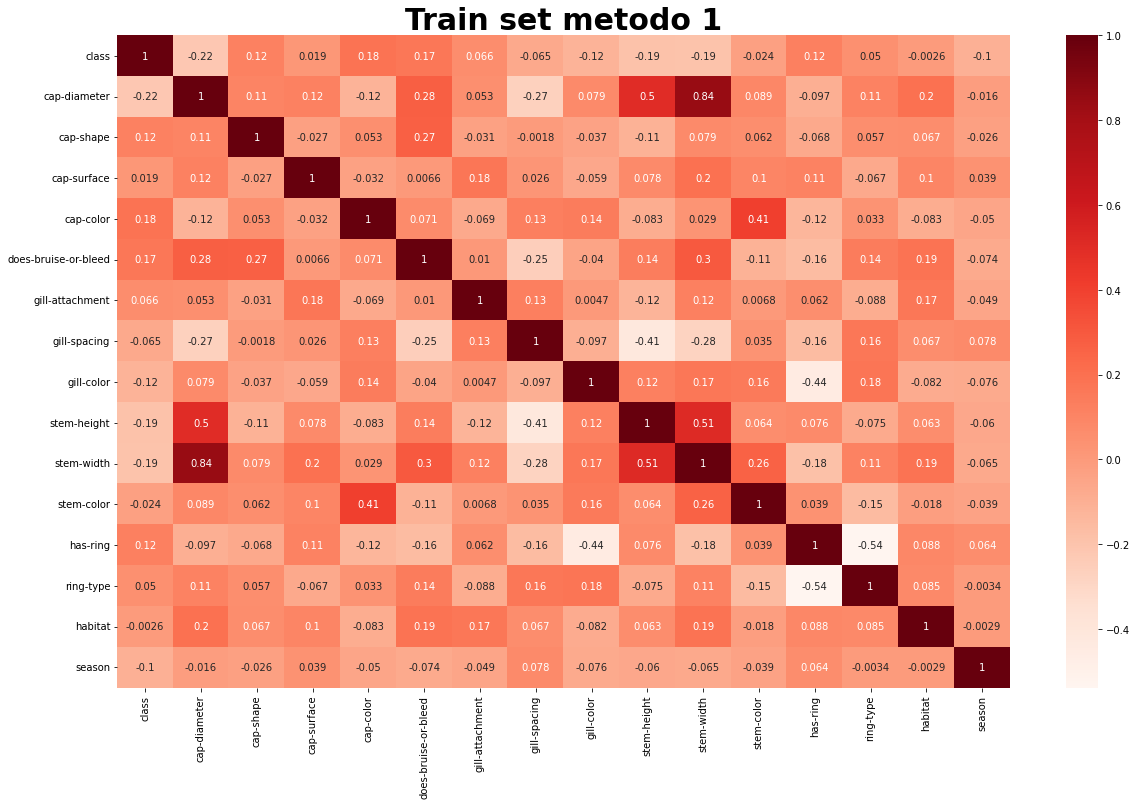

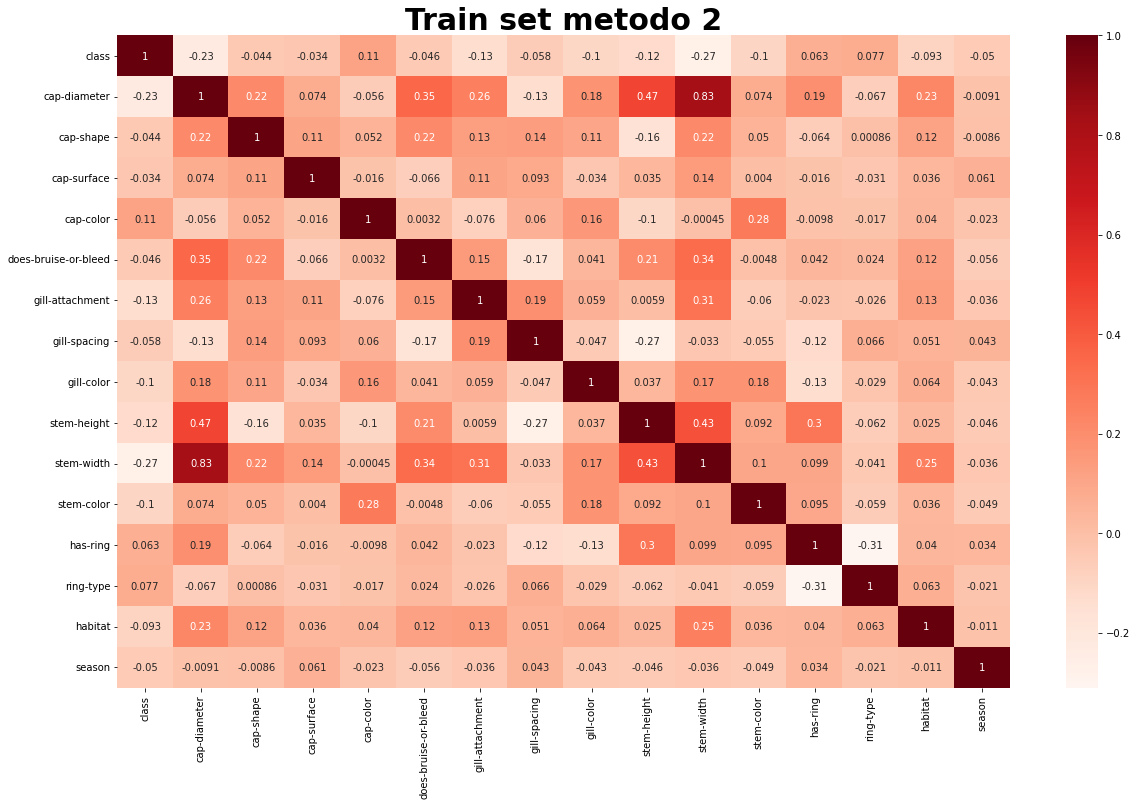

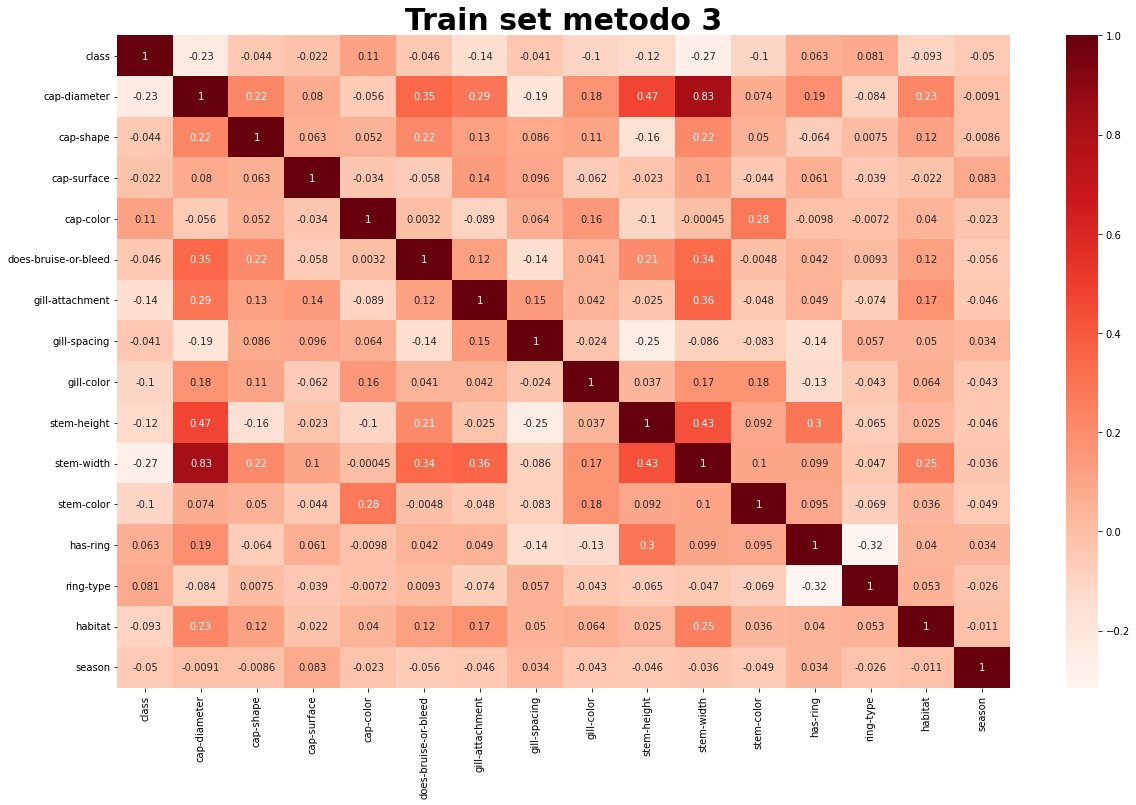

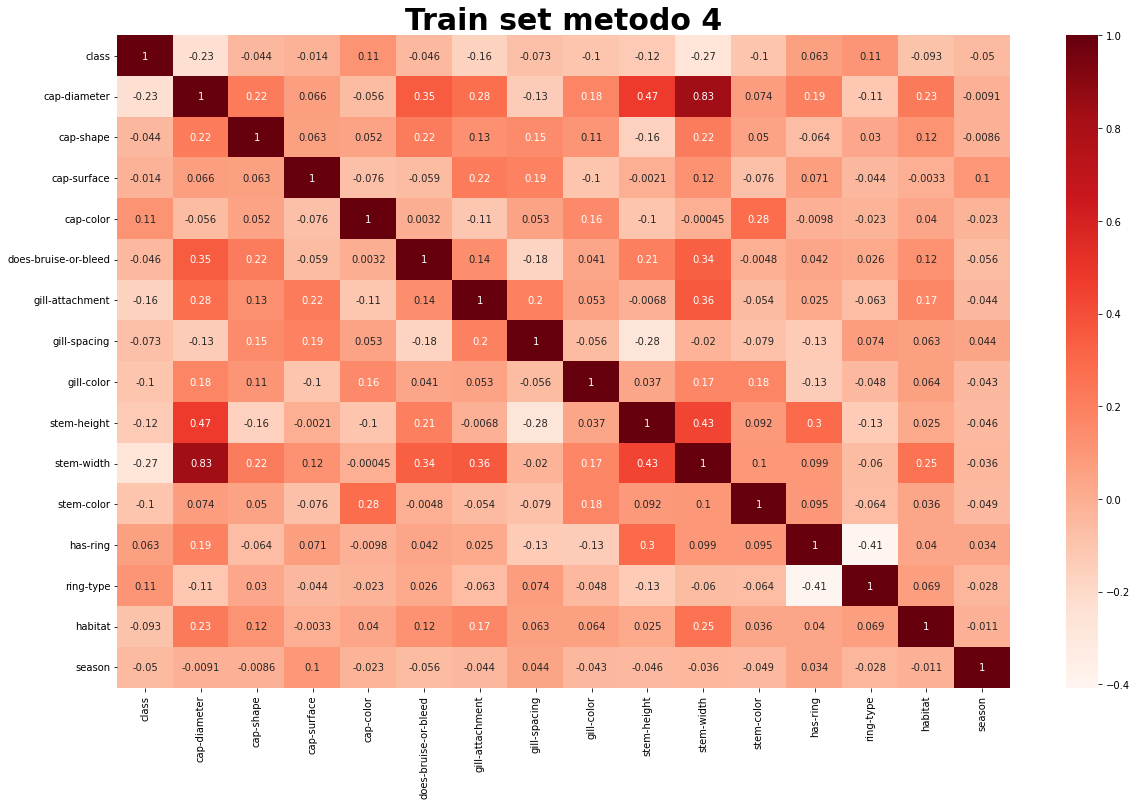

In [54]:
plt.figure(figsize=(20,12))
plt.title("Train set metodo 1",fontsize=30,fontweight="bold")
cor = train_set_metodo1_float.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

plt.figure(figsize=(20,12))
plt.title("Train set metodo 2",fontsize=30,fontweight="bold")
cor = train_set_metodo2_float.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

plt.figure(figsize=(20,12))
plt.title("Train set metodo 3",fontsize=30,fontweight="bold")
cor = train_set_metodoKNN.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

plt.figure(figsize=(20,12))
plt.title("Train set metodo 4",fontsize=30,fontweight="bold")
cor = train_set_metodo4.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


Andando ad analizzare la correlazione delle variabili possiamo notare come sia presente un'alta correlazione, di 0.83, tra "Cap-diameter" e "Stem-width", abbiamo quindi deciso di eliminare la variabile "Stem-width", in quanto abbiamo ritenuto che la correlazione fosse abbastanza alta da giustificare la rimozione senza incorrere in una perdita di informazione troppo elevata.


In [55]:
# eliminiamo la variabile da tutti i trainset che stiamo considerando
train_set_metodo1_float.drop(['stem-width'],axis=1,inplace=True)
train_set_metodo2_float.drop(['stem-width'],axis=1,inplace=True)
train_set_metodoKNN.drop(['stem-width'],axis=1,inplace=True)
train_set_metodo4.drop(['stem-width'],axis=1,inplace=True)


### Feature subselection

Andiamo a calcolare secondo "Univariate Approach" lo score delle feature in modo da osservare l'importanze delle feature per la classificazione

####Univariate Approach

In [56]:
def get_feature_univ_scores(univ_fselector, columns, sort_by: str = "score"):
    return pd.DataFrame(
        data=[univ_fselector.scores_, univ_fselector.pvalues_],
        index=["score", "pvalue"],
        columns=columns,
    ).T.sort_values(by=sort_by, ascending=False)

In [57]:
def FS_Kbest(ds: pd.DataFrame):
  # Create the feature selector
  kbest = SelectKBest(k=3)
  kbest.fit(ds, ds["class"])
  # Print selected columns
  print(ds.columns[kbest.get_support()])
  # Feature selection scores and pvalues analysis
  print(get_feature_univ_scores(kbest, train_set_metodo4.columns, sort_by="score"))

In [58]:
print("Train set metodo 1 Analysis: \n")
FS_Kbest(train_set_metodo1_float)
print("\nTrain set metodo 2 Analysis")
FS_Kbest(train_set_metodo2_float)
print("\nTrain set metodo 3 Analysis:")
FS_Kbest(train_set_metodoKNN)
print("\nTrain set metodo 4 Analysis:")
FS_Kbest(train_set_metodo4)

Train set metodo 1 Analysis: 

Index(['class', 'cap-diameter', 'stem-height'], dtype='object')
                           score         pvalue
class                        inf   0.000000e+00
cap-diameter          991.122153  2.248174e-212
stem-height           737.854757  1.360814e-159
cap-color             693.117771  3.359082e-150
does-bruise-or-bleed  562.247298  1.332217e-122
has-ring              310.511667   5.605307e-69
cap-shape             283.706166   3.187259e-63
gill-color            273.334808   5.401935e-61
season                209.947828   2.448348e-47
gill-attachment        86.290038   1.708487e-20
gill-spacing           84.088777   5.176633e-20
ring-type              49.518323   2.028758e-12
stem-color             11.315862   7.699189e-04
cap-surface             7.483784   6.231194e-03
habitat                 0.139384   7.088979e-01

Train set metodo 2 Analysis
Index(['class', 'cap-diameter', 'gill-attachment'], dtype='object')
                            score       

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Possiamo notare come nel primo dataset, quello ottenuto per eliminazione delle righe contenenti missing values, ci sia una distinzione molto netta fra le prime 8 variabili e quelle successive, dal punto di vista dell'importanza.

Tale distinzione pare essere più marcata per quanto riguarda i successivi 3 dataset, tutti ottenuti tramite una stima dei missing values. In questi abbiamo però che la discesa del valore di importanza è più graduale.

#### Random Forest

Andiamo ora a visionare l'importanza delle variabili attraverso il metodo delle random forest

In [59]:
from sklearn.ensemble import RandomForestClassifier
Y_train=train_set_metodo1_float.iloc[:,0]
X_train=train_set_metodo1_float.iloc[:,1:14]


Visto che le random forest non lavorano su float per quanto riguarda un task di classificazione, effettuiamo il cast dei 2 valori non interi, ovvero "cap-diameter" e "stem-height".

In [60]:
train_set_metodo1_RF = train_set_metodo1_float.copy(deep=True)
train_set_metodo1_RF.round(decimals=0)
train_set_metodo2_RF = train_set_metodo2_float.copy(deep=True)
train_set_metodo2_RF.round(decimals=0)
train_set_metodo3_RF = train_set_metodoKNN.copy(deep=True)
train_set_metodo3_RF.round(decimals=0)
train_set_metodo4_RF = train_set_metodo4.copy(deep=True)
train_set_metodo4_RF.round(decimals=0)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-color,has-ring,ring-type,habitat,season
0,0,1.0,1,3,2,0,0,0,3,4.0,4,0,4,2,0
1,1,4.0,2,6,6,0,0,0,1,4.0,7,1,6,7,3
2,0,9.0,4,6,2,0,4,0,10,4.0,2,0,4,7,0
3,1,3.0,3,10,2,1,2,0,11,3.0,2,0,4,7,2
4,0,4.0,2,6,2,0,1,0,1,6.0,11,0,4,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54609,1,6.0,6,0,11,0,2,0,11,2.0,7,0,4,1,2
54610,1,8.0,2,2,2,0,0,0,1,12.0,2,0,4,1,0
54611,1,12.0,3,6,2,0,3,0,10,11.0,11,1,2,7,2
54612,1,7.0,2,8,2,1,6,1,4,6.0,11,0,4,7,2


In [61]:
from sklearn.ensemble import RandomForestClassifier
Y_train1=train_set_metodo1_RF.iloc[:,0]
X_train1=train_set_metodo1_RF.iloc[:,1:15]
Y_train2=train_set_metodo2_RF.iloc[:,0]
X_train2=train_set_metodo2_RF.iloc[:,1:15]
Y_train3=train_set_metodo3_RF.iloc[:,0]
X_train3=train_set_metodo3_RF.iloc[:,1:15]
Y_train4=train_set_metodo4_RF.iloc[:,0]
X_train4=train_set_metodo4_RF.iloc[:,1:15]
##METTERE 1:15

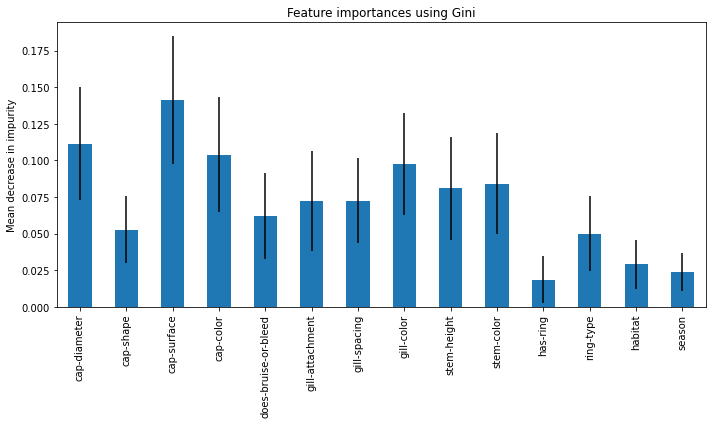

In [62]:
# considerare di cambiare il min_samples_leaf per alzarlo un po'
# considerare il warm_start 

forest1 = RandomForestClassifier(random_state=42,oob_score = True, min_samples_leaf=1,max_features="sqrt",
                                 bootstrap=True,warm_start=True)
forest1.fit(X_train1.values, Y_train1.values)

importances = forest1.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest1.estimators_], axis=0)

forest_importances1 = pd.Series(importances, index=X_train1.columns)

fig, ax = plt.subplots()
forest_importances1.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Gini")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

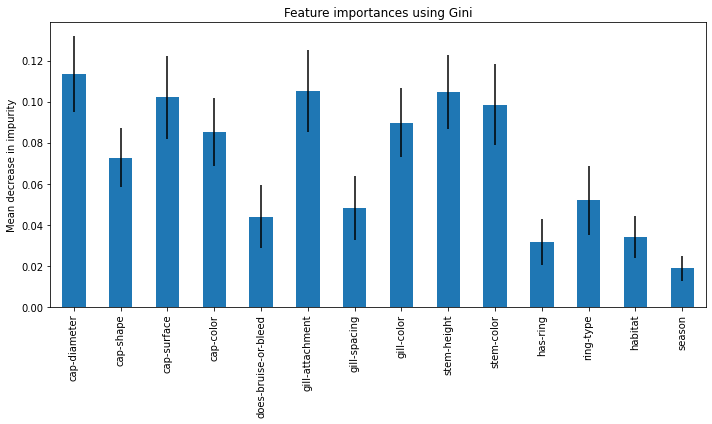

In [63]:
forest2 = RandomForestClassifier(random_state=42,oob_score = True, min_samples_leaf=1,max_features="sqrt",
                                 bootstrap=True,warm_start=True)
forest2.fit(X_train2.values, Y_train2.values)

importances = forest2.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest2.estimators_], axis=0)

forest_importances2 = pd.Series(importances, index=X_train2.columns)

fig, ax = plt.subplots()
forest_importances2.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Gini")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

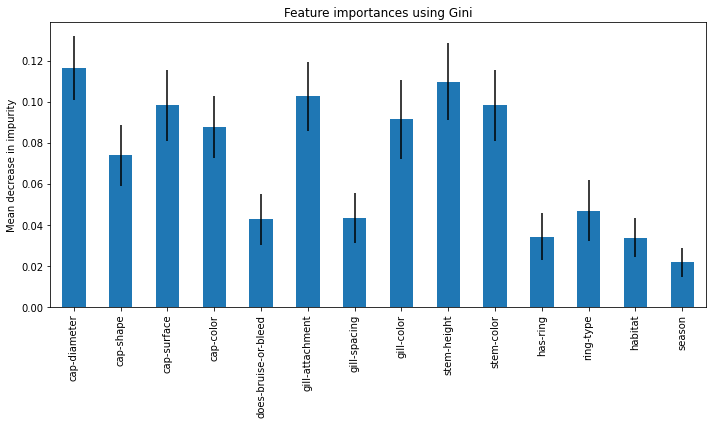

In [64]:
forest3 = RandomForestClassifier(random_state=42,oob_score = True, min_samples_leaf=1,max_features="sqrt",bootstrap=True,warm_start=True)
forest3.fit(X_train3.values, Y_train3.values)

importances = forest3.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest3.estimators_], axis=0)

forest_importances3 = pd.Series(importances, index=X_train2.columns)

fig, ax = plt.subplots()
forest_importances3.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Gini")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

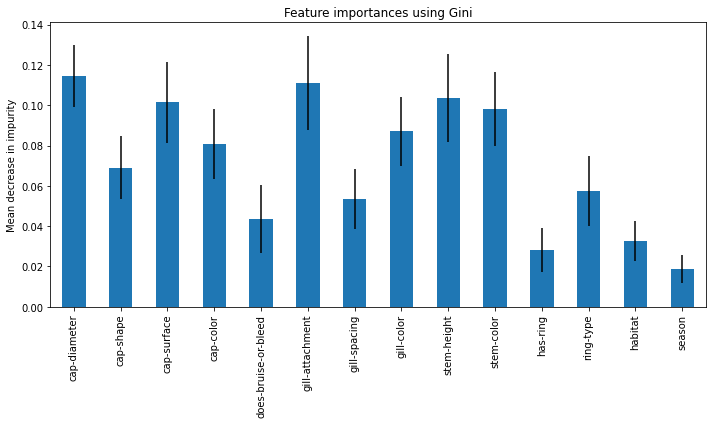

In [65]:
forest4 = RandomForestClassifier(random_state=42,oob_score = True, min_samples_leaf=1,max_features="sqrt",bootstrap=True,warm_start=True)
forest4.fit(X_train4.values, Y_train4.values)

importances = forest4.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest4.estimators_], axis=0)

forest_importances4 = pd.Series(importances, index=X_train2.columns)

fig, ax = plt.subplots()
forest_importances4.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Gini")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Feature elimination

In [66]:
# Decido di droppare da ogni dataset le 4 colonne meno importanti, in modo tale da avere 10 features in totale
train_set_metodo1_float.drop(["habitat","season","ring-type","has-ring"], axis=1, inplace=True)
train_set_metodo2_float.drop(["habitat","season","ring-type","has-ring"], axis=1, inplace=True)
train_set_metodoKNN.drop(["habitat","season","ring-type","has-ring"], axis=1, inplace=True)
train_set_metodo4.drop(["habitat","season","ring-type","has-ring"], axis=1, inplace=True)

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## Addestramento modelli

In [68]:
#Ora splittiamo il dataset usato con train_test_split per capire se gli score hanno senso (si può togliere in futuro)
y1 = train_set_metodo1_float.iloc[:,0]
x1 = train_set_metodo1_float.iloc[:,1:11]

y2 = train_set_metodo2_float.iloc[:,0]
x2 = train_set_metodo2_float.iloc[:,1:11]

y3 = train_set_metodoKNN.iloc[:,0]
x3 = train_set_metodoKNN.iloc[:,1:11]

y4 = train_set_metodo4.iloc[:,0]
x4 = train_set_metodo4.iloc[:,1:11]

In [69]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, random_state=42)
X_train3, X_test3, y_train3, y_test3 = train_test_split(x3, y3, random_state=42)
X_train4, X_test4, y_train4, y_test4 = train_test_split(x4, y4, random_state=42)

In [70]:
X_train1.shape

(15018, 10)

In [71]:
y_train1.shape

(15018,)

### SVC

In [72]:
#Utilizziamo come primo modello una SVC con kernel lineare.
svc=SVC(kernel='linear',C=1) 

# fit classifier to training set1
svc.fit(X_train1,y_train1)

# make predictions on test set1
y_pred1=svc.predict(X_test1)

# compute and print accuracy score1
print('Model 1 accuracy score with default hyperparameters with linear kernel (dataset1): {0:0.4f}'. format(accuracy_score(y_test1, y_pred1)))

# fit classifier to training set2
svc.fit(X_train2,y_train2)

# make predictions on test set2
y_pred2=svc.predict(X_test2)

# compute and print accuracy score2
print('Model 2 accuracy score with default hyperparameters with linear kernel (dataset2): {0:0.4f}'. format(accuracy_score(y_test2, y_pred2)))

# fit classifier to training set3
svc.fit(X_train3,y_train3)

# make predictions on test set3
y_pred3=svc.predict(X_test3)

# compute and print accuracy score3
print('Model 3 accuracy score with default hyperparameters with linear kernel (dataset3): {0:0.4f}'. format(accuracy_score(y_test3, y_pred3)))

# fit classifier to training set4
svc.fit(X_train4,y_train4)

# make predictions on test set4
y_pred4=svc.predict(X_test4)

# compute and print accuracy score4
print('Model 4 accuracy score with default hyperparameters with linear kernel (dataset4): {0:0.4f}'. format(accuracy_score(y_test4, y_pred4)))

Model 1 accuracy score with default hyperparameters with linear kernel (dataset1): 0.7361
Model 2 accuracy score with default hyperparameters with linear kernel (dataset2): 0.6285
Model 3 accuracy score with default hyperparameters with linear kernel (dataset3): 0.6327
Model 4 accuracy score with default hyperparameters with linear kernel (dataset4): 0.6276


In [73]:
#SVC con kernel lineare non hanno dato i risultati aspettati. Quindi proviamo a cambiare kernel.
#Utilizziamo come parametro C un parametro abbastanza basso (10) e kernel rbf: Nonostante avessimo rimosso degli
#outliers ne rimanevano comunque.
svc=SVC(C=10) 

# fit classifier to training set1
svc.fit(X_train1,y_train1)

# make predictions on test set1
y_pred1=svc.predict(X_test1)

# compute and print accuracy score1
print('Model 1 accuracy score with default hyperparameters with C=10 (dataset1): {0:0.4f}'. format(accuracy_score(y_test1, y_pred1)))

# fit classifier to training set2
svc.fit(X_train2,y_train2)

# make predictions on test set2
y_pred2=svc.predict(X_test2)

# compute and print accuracy score2
print('Model 2 accuracy score with default hyperparameters with C=10 (dataset2): {0:0.4f}'. format(accuracy_score(y_test2, y_pred2)))

# fit classifier to training set3
svc.fit(X_train3,y_train3)

# make predictions on test set3
y_pred3=svc.predict(X_test3)

# compute and print accuracy score3
print('Model 3 accuracy score with default hyperparameters with C=10 (dataset3): {0:0.4f}'. format(accuracy_score(y_test3, y_pred3)))

# fit classifier to training set4
svc.fit(X_train4,y_train4)

# make predictions on test set4
y_pred4=svc.predict(X_test4)

# compute and print accuracy score4
print('Model 4 accuracy score with default hyperparameters with C=10 (dataset4): {0:0.4f}'. format(accuracy_score(y_test4, y_pred4)))

Model 1 accuracy score with default hyperparameters with C=10 (dataset1): 0.9914
Model 2 accuracy score with default hyperparameters with C=10 (dataset2): 0.9563
Model 3 accuracy score with default hyperparameters with C=10 (dataset3): 0.9469
Model 4 accuracy score with default hyperparameters with C=10 (dataset4): 0.9552


### Extra Trees

In [74]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

extra_tree_forest = ExtraTreesClassifier(oob_score=True, bootstrap=True,n_estimators=30,
                            criterion = "gini", max_features = "auto", random_state=42)

extra_tree_forest.fit(X_train1,y_train1)
y_pred1 = extra_tree_forest.predict(X_test1)
feature_importance1 = extra_tree_forest.feature_importances_

extra_tree_forest.fit(X_train2,y_train2)
y_pred2 = extra_tree_forest.predict(X_test2)
feature_importance2 = extra_tree_forest.feature_importances_

extra_tree_forest.fit(X_train3,y_train3)
y_pred3 = extra_tree_forest.predict(X_test3)
feature_importance3 = extra_tree_forest.feature_importances_

extra_tree_forest.fit(X_train4,y_train4)
y_pred4 = extra_tree_forest.predict(X_test4)
feature_importance4 = extra_tree_forest.feature_importances_

In [75]:
print('Model 1 accuracy score with extra trees (dataset1): {0:0.4f}'. format(accuracy_score(y_test1, y_pred1)))
print('Model 2 accuracy score with extra trees (dataset2): {0:0.4f}'. format(accuracy_score(y_test2, y_pred2)))
print('Model 3 accuracy score with extra trees (dataset3): {0:0.4f}'. format(accuracy_score(y_test3, y_pred3)))
print('Model 4 accuracy score with extra trees (dataset4): {0:0.4f}'. format(accuracy_score(y_test4, y_pred4)))

Model 1 accuracy score with extra trees (dataset1): 0.9996
Model 2 accuracy score with extra trees (dataset2): 0.9975
Model 3 accuracy score with extra trees (dataset3): 0.9987
Model 4 accuracy score with extra trees (dataset4): 0.9990


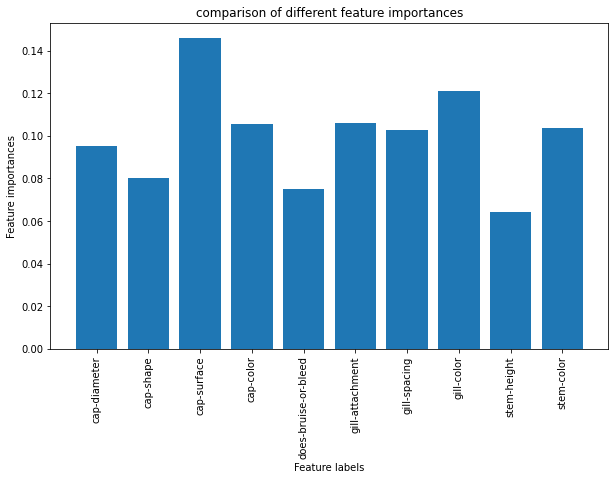

<Figure size 20000x12000 with 0 Axes>

In [76]:
plt.bar(X_train1.columns, feature_importance1)
plt.xlabel("Feature labels")
plt.xticks(rotation=90)
plt.ylabel("Feature importances")
plt.title("comparison of different feature importances")
plt.figure(dpi=2000)
plt.show()

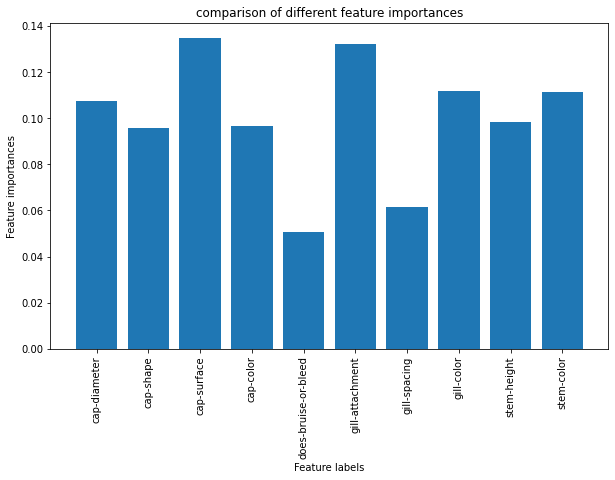

<Figure size 20000x12000 with 0 Axes>

In [77]:
plt.bar(X_train1.columns, feature_importance2)
plt.xlabel("Feature labels")
plt.xticks(rotation=90)
plt.ylabel("Feature importances")
plt.title("comparison of different feature importances")
plt.figure(dpi=2000)
plt.show()

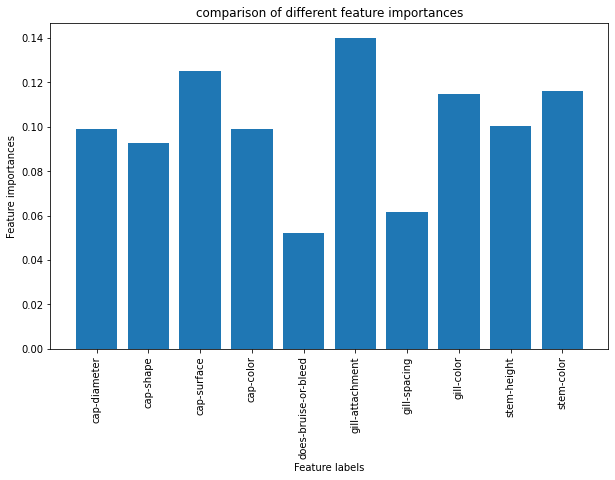

<Figure size 20000x12000 with 0 Axes>

In [78]:
plt.bar(X_train1.columns, feature_importance3)
plt.xlabel("Feature labels")
plt.xticks(rotation=90)
plt.ylabel("Feature importances")
plt.title("comparison of different feature importances")
plt.figure(dpi=2000)
plt.show()

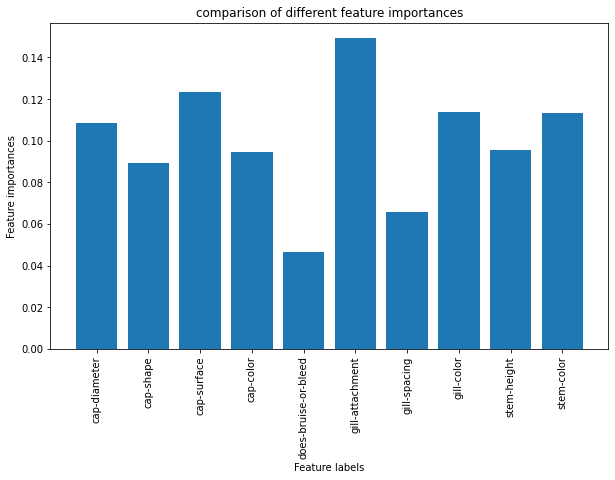

<Figure size 20000x12000 with 0 Axes>

In [79]:
plt.bar(X_train1.columns, feature_importance4)
plt.xlabel("Feature labels")
plt.xticks(rotation=90)
plt.ylabel("Feature importances")
plt.title("comparison of different feature importances")
plt.figure(dpi=2000)
plt.show()

### Bagging

In [80]:
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=424)
clf.fit(X_train1,y_train1)
ypred1_albero = clf.predict(X_test1)
print(clf.tree_.max_depth)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=424), n_estimators=500,
      bootstrap=True, random_state=42)
bag_clf.fit(X_train1, y_train1)
y_pred1 = bag_clf.predict(X_test1)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=424), n_estimators=500,
      bootstrap=True, random_state=42)
bag_clf.fit(X_train2, y_train2)
y_pred2 = bag_clf.predict(X_test2)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=424), n_estimators=500,
      bootstrap=True, random_state=42)
bag_clf.fit(X_train3, y_train3)
y_pred3 = bag_clf.predict(X_test3)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=424), n_estimators=500,
      bootstrap=True, random_state=42)
bag_clf.fit(X_train4, y_train4)
y_pred4 = bag_clf.predict(X_test4)

14


In [81]:
print('Model 1 accuracy score with bagging with 1 tree (dataset1): {0:0.4f}'. format(accuracy_score(y_test1, ypred1_albero)))
print('Model 1 accuracy score with bagging with 500 trees (dataset1): {0:0.4f}'. format(accuracy_score(y_test1, y_pred1)))
print('Model 2 accuracy score with bagging with 500 trees (dataset2): {0:0.4f}'. format(accuracy_score(y_test2, y_pred2)))
print('Model 3 accuracy score with bagging with 500 trees (dataset3): {0:0.4f}'. format(accuracy_score(y_test3, y_pred3)))
print('Model 4 accuracy score with bagging with 500 trees (dataset4): {0:0.4f}'. format(accuracy_score(y_test4, y_pred4)))

Model 1 accuracy score with bagging with 1 tree (dataset1): 0.9960
Model 1 accuracy score with bagging with 500 trees (dataset1): 0.9968
Model 2 accuracy score with bagging with 500 trees (dataset2): 0.9961
Model 3 accuracy score with bagging with 500 trees (dataset3): 0.9952
Model 4 accuracy score with bagging with 500 trees (dataset4): 0.9971


In [82]:
"""from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
y1_ = train_set_metodo1.iloc[:,0]
x1_ = train_set_metodo1.iloc[:,1:11]

enc.fit(x1_)
X1_ = enc.transform(x1_)

#X_train1_, X_test1_, y_train1_, y_test1_ = train_test_split(x1_, y1_, random_state=42) """

"from sklearn.preprocessing import OneHotEncoder\n\nenc = OneHotEncoder(handle_unknown='ignore')\ny1_ = train_set_metodo1.iloc[:,0]\nx1_ = train_set_metodo1.iloc[:,1:11]\n\nenc.fit(x1_)\nX1_ = enc.transform(x1_)\n\n#X_train1_, X_test1_, y_train1_, y_test1_ = train_test_split(x1_, y1_, random_state=42) "

In [83]:
"""bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=424), n_estimators=500,
      bootstrap=True, random_state=42)
bag_clf.fit(X_train1_, y_train1_)
y_pred1_ = bag_clf.predict(X_test1_) """

'bag_clf = BaggingClassifier(\n    DecisionTreeClassifier(random_state=424), n_estimators=500,\n      bootstrap=True, random_state=42)\nbag_clf.fit(X_train1_, y_train1_)\ny_pred1_ = bag_clf.predict(X_test1_) '

### Neural Nets

In [84]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.9.2


In [85]:
numhiddens=5
numhneurons=50
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_dim=X_train1.shape[1]))
model.add(tf.keras.layers.Dense(200, activation='relu'))
for _ in range(numhiddens):
    model.add(tf.keras.layers.Dense(numhneurons, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(2,activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 200)               2200      
                                                                 
 dense_1 (Dense)             (None, 50)                10050     
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 dense_5 (Dense)             (None, 50)                2

In [86]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [87]:
training = model.fit(X_train1, y_train1, validation_split=0.2, epochs=10)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


374/376 [============================>.] - ETA: 0s - loss: 0.3330 - accuracy: 0.8427

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


376/376 [==============================] - 3s 5ms/step - loss: 0.3325 - accuracy: 0.8429 - val_loss: 0.1636 - val_accuracy: 0.9248
Epoch 2/10
376/376 [==============================] - 2s 5ms/step - loss: 0.1252 - accuracy: 0.9544 - val_loss: 0.0464 - val_accuracy: 0.9874
Epoch 3/10
376/376 [==============================] - 2s 4ms/step - loss: 0.0685 - accuracy: 0.9768 - val_loss: 0.2109 - val_accuracy: 0.9264
Epoch 4/10
376/376 [==============================] - 2s 4ms/step - loss: 0.0418 - accuracy: 0.9851 - val_loss: 0.0227 - val_accuracy: 0.9940
Epoch 5/10
376/376 [==============================] - 2s 4ms/step - loss: 0.0410 - accuracy: 0.9867 - val_loss: 0.0288 - val_accuracy: 0.9917
Epoch 6/10
376/376 [==============================] - 1s 4ms/step - loss: 0.0347 - accuracy: 0.9890 - val_loss: 0.0136 - val_accuracy: 0.9963
Epoch 7/10
376/376 [==============================] - 2s 4ms/step - loss: 0.0246 - accuracy: 0.9917 - val_loss: 0.0060 - val_accuracy: 0.9993
Epoch 8/10
376/37

In [88]:
test_loss, test_acc = model.evaluate(X_test1,y_test1, verbose=2)
print('\nTest accuracy:', test_acc)

157/157 - 0s - loss: 0.0195 - accuracy: 0.9932 - 218ms/epoch - 1ms/step

Test accuracy: 0.9932081699371338


### Auto-Sklearn

In [91]:
!pip install -U auto-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 260 kB 45.1 MB/s 
     |████████████████████████████████| 4.9 MB 37.9 MB/s 
     |████████████████████████████████| 4.4 MB 43.3 MB/s 
     |████████████████████████████████| 24.9 MB 45.5 MB/s 
     |████████████████████████████████| 46 kB 2.5 MB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.15.0-py3-none-any.whl size=6641945 sha256=38c3c35d235cc46c53d4dffab337143b8c1c704441ce3c84f1d3dad826813c1a
  Stored in directory: /root/.cache/pip/wheels/c5/11/0e/aeac2cee929fa4388e528737b49deb2eea05486e6f80d61c1a
  Created wheel for pynisher: filename=pynisher-0.6.4-py3-none-any.whl size=7044 sha256=560a6cae329d8372f2d9fd62f64647a6e2dce6e98a10461e9a49bfc1ab8f3c4a
  St

In [92]:
import autosklearn.classification
import sklearn.metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import (accuracy,
                                 f1,
                                 roc_auc,
                                 precision,
                                 average_precision,
                                 recall,
                                 log_loss)

FileNotFoundError: ignored

In [ ]:
train_set_metodo1.drop(["habitat","season","ring-type","has-ring","stem-width"], axis=1, inplace=True)
num_cols = ['cap-diameter','stem-height']
cat_cols = ['class', 'cap-shape','cap-surface',	'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-color'] 
train_set_metodo1[num_cols] = train_set_metodo1[num_cols].apply(pd.to_numeric)
train_set_metodo1[cat_cols] = train_set_metodo1[cat_cols].apply(pd.Categorical)
y1_cat = train_set_metodo1.iloc[:,0]
x1_cat = train_set_metodo1.iloc[:,1:11]
X_train1_cat, X_test1_cat, y_train1_cat, y_test1_cat = train_test_split(x1_cat, y1_cat, random_state=42,stratify=y1_cat)

In [ ]:
clf = AutoSklearnClassifier(
    time_left_for_this_task=300,
    per_run_time_limit=30,
    include={
        "classifier": ["decision_tree", "extra_trees", "random_forest","adaboost"],
        "feature_preprocessor": [
            "no_preprocessing",
            "polynomial",
            "select_percentile_classification",
        ],
    },
    ensemble_kwargs={"ensemble_size": 1},
)

In [ ]:
clf.fit(X_train1_cat, y_train1_cat)

In [ ]:
clf.leaderboard(detailed = True, ensemble_only=False)

In [ ]:
df_cv_results = pd.DataFrame(clf.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
df_cv_results

In [ ]:
predictions = clf.predict(X_test1_cat)
print("Accuracy score:", sklearn.metrics.accuracy_score(y_test1_cat, predictions))

In [ ]:
"""import PipelineProfiler
data = PipelineProfiler.import_autosklearn(clf)
PipelineProfiler.plot_pipeline_matrix(data)"""